In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/CIRUGIA CARDIOVASCULAR.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 11 questions
Page 1, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=99.0, y1=114.8
Page 1, Q1, A: Yellow pixels: 879
Page 1, Q1, A: Total non-white pixels: 972
Page 1, Q1, A: Yellow percentage: 90.4%


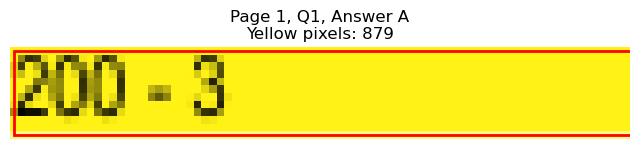

Page 1, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=99.0, y1=127.4
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 116
Page 1, Q1, B: Yellow percentage: 0.0%


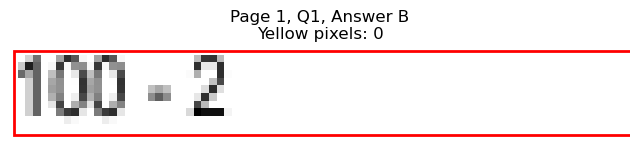

Page 1, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=363.2, y1=114.8
Page 1, Q1, C: Yellow pixels: 0
Page 1, Q1, C: Total non-white pixels: 141
Page 1, Q1, C: Yellow percentage: 0.0%


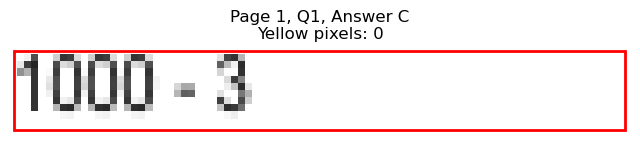

Page 1, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=353.2, y1=127.4
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 97
Page 1, Q1, D: Yellow percentage: 0.0%


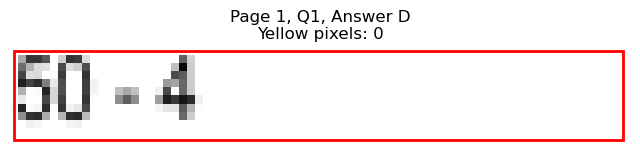


Page 1, Q1 - Selected Answer: A (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=177.6, y1=165.3
Page 1, Q2, A: Yellow pixels: 160
Page 1, Q2, A: Total non-white pixels: 720
Page 1, Q2, A: Yellow percentage: 22.2%


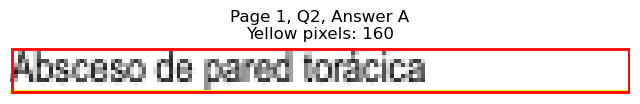

Page 1, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=155.0, y1=177.9
Page 1, Q2, B: Yellow pixels: 1325
Page 1, Q2, B: Total non-white pixels: 1656
Page 1, Q2, B: Yellow percentage: 80.0%


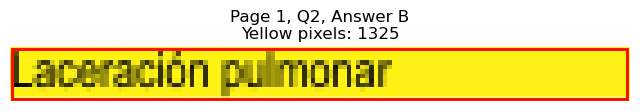

Page 1, Q2 - C: Detected box: x0=327.5, y0=154.3, x1=411.7, y1=165.3
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 425
Page 1, Q2, C: Yellow percentage: 0.0%


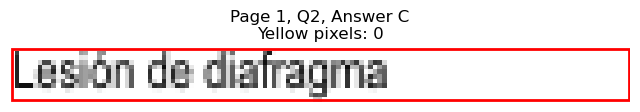

Page 1, Q2 - D: Detected box: x0=327.5, y0=166.9, x1=443.4, y1=177.9
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 580
Page 1, Q2, D: Yellow percentage: 0.0%


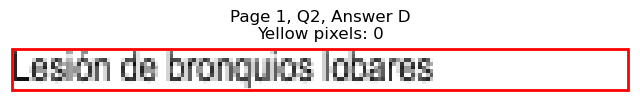


Page 1, Q2 - Selected Answer: B (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=68.3, y0=217.4, x1=88.8, y1=228.4
Page 1, Q3, A: Yellow pixels: 703
Page 1, Q3, A: Total non-white pixels: 852
Page 1, Q3, A: Yellow percentage: 82.5%


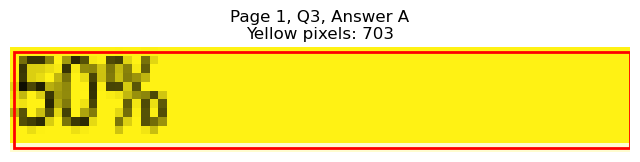

Page 1, Q3 - B: Detected box: x0=68.3, y0=230.0, x1=101.9, y1=241.0
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 171
Page 1, Q3, B: Yellow percentage: 0.0%


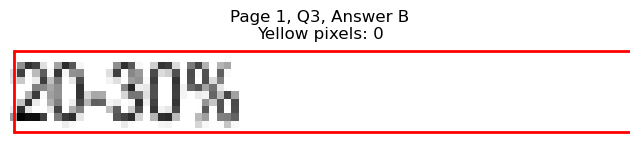

Page 1, Q3 - C: Detected box: x0=327.5, y0=217.4, x1=361.1, y1=228.4
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 172
Page 1, Q3, C: Yellow percentage: 0.0%


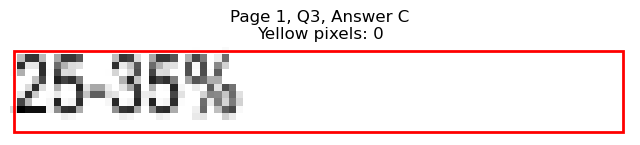

Page 1, Q3 - D: Detected box: x0=327.5, y0=230.0, x1=361.1, y1=241.0
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 174
Page 1, Q3, D: Yellow percentage: 0.0%


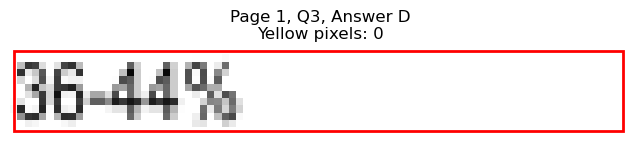


Page 1, Q3 - Selected Answer: A (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=124.4, y1=304.2
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 315
Page 1, Q4, A: Yellow percentage: 0.0%


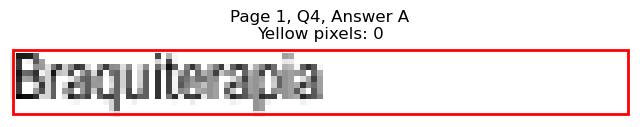

Page 1, Q4 - B: Detected box: x0=68.3, y0=305.7, x1=127.0, y1=316.8
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 299
Page 1, Q4, B: Yellow percentage: 0.0%


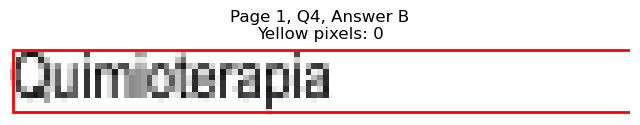

Page 1, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=531.0, y1=304.2
Page 1, Q4, C: Yellow pixels: 213
Page 1, Q4, C: Total non-white pixels: 1436
Page 1, Q4, C: Yellow percentage: 14.8%


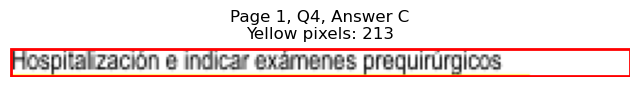

Page 1, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=473.5, y1=316.8
Page 1, Q4, D: Yellow pixels: 1828
Page 1, Q4, D: Total non-white pixels: 2364
Page 1, Q4, D: Yellow percentage: 77.3%


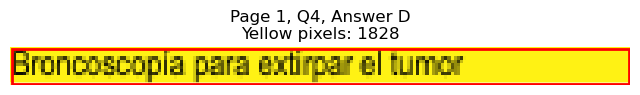


Page 1, Q4 - Selected Answer: D (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=138.5, y1=354.7
Page 1, Q5, A: Yellow pixels: 1156
Page 1, Q5, A: Total non-white pixels: 1452
Page 1, Q5, A: Yellow percentage: 79.6%


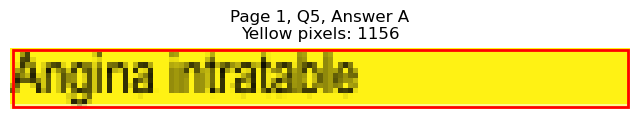

Page 1, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=161.5, y1=367.3
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 448
Page 1, Q5, B: Yellow percentage: 0.0%


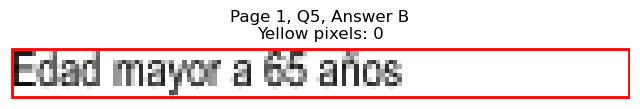

Page 1, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=498.7, y1=354.7
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 819
Page 1, Q5, C: Yellow percentage: 0.0%


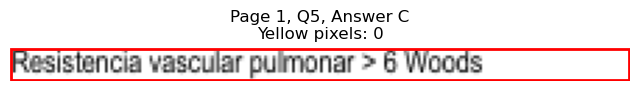

Page 1, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=477.7, y1=367.3
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 724
Page 1, Q5, D: Yellow percentage: 0.0%


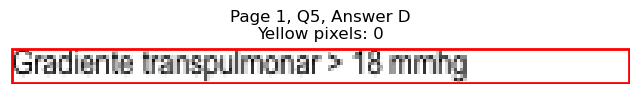


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=347.6, y1=405.1
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 1395
Page 1, Q6, A: Yellow percentage: 0.0%


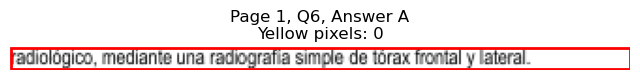

Page 1, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=373.2, y1=417.7
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 1574
Page 1, Q6, B: Yellow percentage: 0.0%


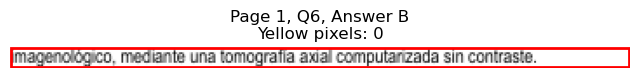

Page 1, Q6 - C: Detected box: x0=68.8, y0=419.4, x1=315.5, y1=430.4
Page 1, Q6, C: Yellow pixels: 298
Page 1, Q6, C: Total non-white pixels: 1489
Page 1, Q6, C: Yellow percentage: 20.0%


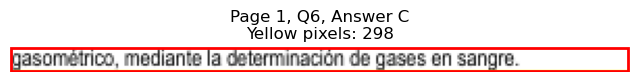

Page 1, Q6 - D: Detected box: x0=68.8, y0=432.0, x1=472.0, y1=443.0
Page 1, Q6, D: Yellow pixels: 3913
Page 1, Q6, D: Total non-white pixels: 5448
Page 1, Q6, D: Yellow percentage: 71.8%


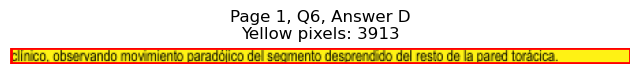


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=135.5, y1=480.8
Page 1, Q7, A: Yellow pixels: 0
Page 1, Q7, A: Total non-white pixels: 324
Page 1, Q7, A: Yellow percentage: 0.0%


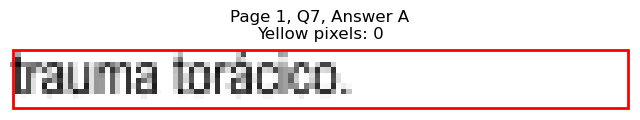

Page 1, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=239.3, y1=493.5
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 849
Page 1, Q7, B: Yellow percentage: 0.0%


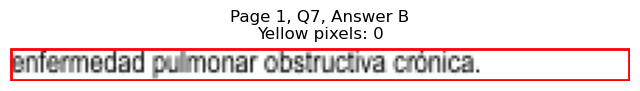

Page 1, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=454.9, y1=480.8
Page 1, Q7, C: Yellow pixels: 1661
Page 1, Q7, C: Total non-white pixels: 2136
Page 1, Q7, C: Yellow percentage: 77.8%


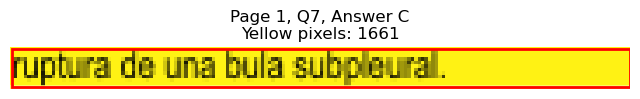

Page 1, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=411.2, y1=493.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 414
Page 1, Q7, D: Yellow percentage: 0.0%


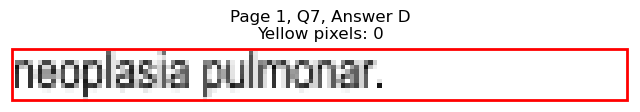


Page 1, Q7 - Selected Answer: C (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=68.3, y0=532.9, x1=189.6, y1=543.9
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 585
Page 1, Q8, A: Yellow percentage: 0.0%


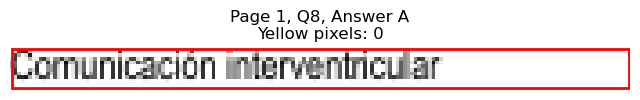

Page 1, Q8 - B: Detected box: x0=68.3, y0=545.5, x1=201.1, y1=556.5
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 675
Page 1, Q8, B: Yellow percentage: 0.0%


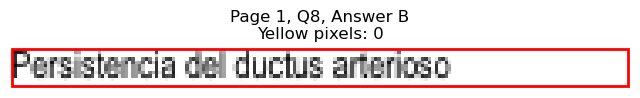

Page 1, Q8 - C: Detected box: x0=327.5, y0=532.9, x1=441.8, y1=543.9
Page 1, Q8, C: Yellow pixels: 1577
Page 1, Q8, C: Total non-white pixels: 1980
Page 1, Q8, C: Yellow percentage: 79.6%


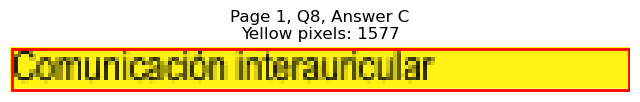

Page 1, Q8 - D: Detected box: x0=327.5, y0=545.5, x1=409.2, y1=556.5
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 407
Page 1, Q8, D: Yellow percentage: 0.0%


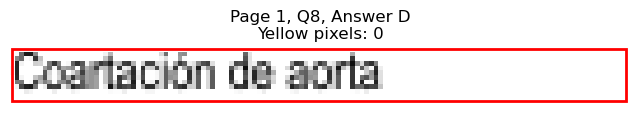


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=68.3, y0=583.4, x1=144.0, y1=594.4
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 388
Page 1, Q9, A: Yellow percentage: 0.0%


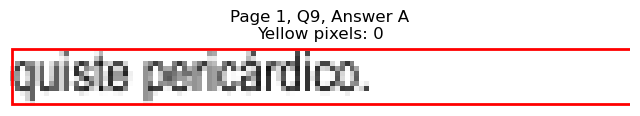

Page 1, Q9 - B: Detected box: x0=68.3, y0=596.0, x1=102.4, y1=607.0
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 168
Page 1, Q9, B: Yellow percentage: 0.0%


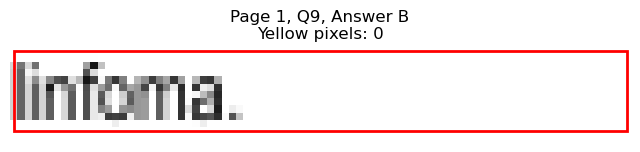

Page 1, Q9 - C: Detected box: x0=327.5, y0=583.4, x1=362.0, y1=594.4
Page 1, Q9, C: Yellow pixels: 824
Page 1, Q9, C: Total non-white pixels: 1032
Page 1, Q9, C: Yellow percentage: 79.8%


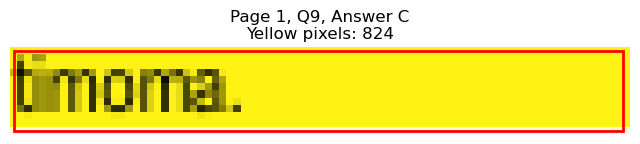

Page 1, Q9 - D: Detected box: x0=327.5, y0=596.0, x1=368.2, y1=607.0
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 201
Page 1, Q9, D: Yellow percentage: 0.0%


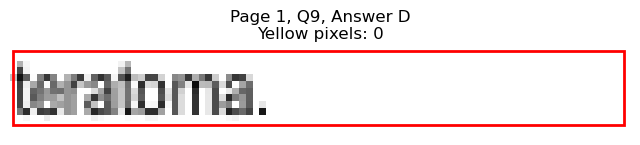


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)




Page 1, Q10 - A: Detected box: x0=56.6, y0=646.5, x1=65.2, y1=657.6
Page 1, Q10, A: Yellow pixels: 0
Page 1, Q10, A: Total non-white pixels: 64
Page 1, Q10, A: Yellow percentage: 0.0%


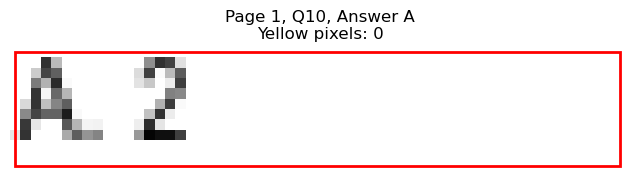

Page 1, Q10 - B: Detected box: x0=56.6, y0=659.1, x1=65.2, y1=670.2
Page 1, Q10, B: Yellow pixels: 0
Page 1, Q10, B: Total non-white pixels: 60
Page 1, Q10, B: Yellow percentage: 0.0%


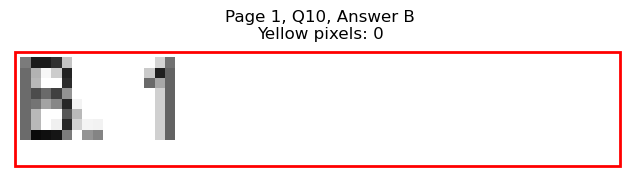

Page 1, Q10 - C: Detected box: x0=315.4, y0=646.5, x1=324.4, y1=657.6
Page 1, Q10, C: Yellow pixels: 611
Page 1, Q10, C: Total non-white pixels: 720
Page 1, Q10, C: Yellow percentage: 84.9%


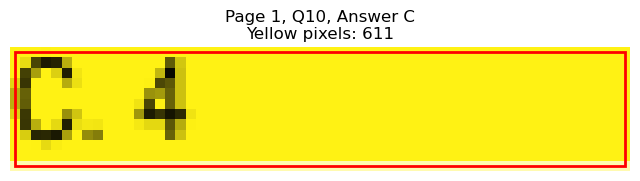

Page 1, Q10 - D: Detected box: x0=315.4, y0=659.1, x1=324.4, y1=670.2
Page 1, Q10, D: Yellow pixels: 0
Page 1, Q10, D: Total non-white pixels: 76
Page 1, Q10, D: Yellow percentage: 0.0%


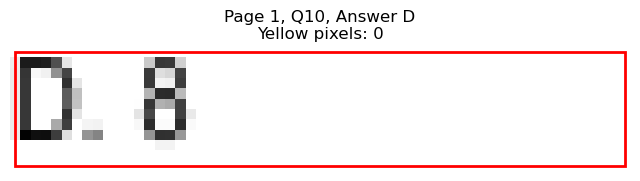


Page 1, Q10 - Selected Answer: C (based on yellow pixel count)




Page 1, Q11 - A: Detected box: x0=68.3, y0=697.0, x1=215.0, y1=708.1
Page 1, Q11, A: Yellow pixels: 0
Page 1, Q11, A: Total non-white pixels: 656
Page 1, Q11, A: Yellow percentage: 0.0%


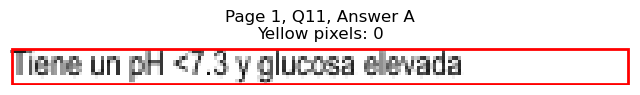

Page 1, Q11 - B: Detected box: x0=68.3, y0=709.6, x1=265.9, y1=720.7
Page 1, Q11, B: Yellow pixels: 0
Page 1, Q11, B: Total non-white pixels: 934
Page 1, Q11, B: Yellow percentage: 0.0%


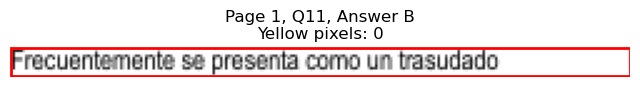

Page 1, Q11 - C: Detected box: x0=327.5, y0=697.0, x1=541.1, y1=708.1
Page 1, Q11, C: Yellow pixels: 1531
Page 1, Q11, C: Total non-white pixels: 2346
Page 1, Q11, C: Yellow percentage: 65.3%


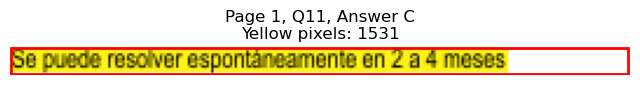

Page 1, Q11 - D: Detected box: x0=327.5, y0=709.6, x1=515.9, y1=720.7
Page 1, Q11, D: Yellow pixels: 0
Page 1, Q11, D: Total non-white pixels: 894
Page 1, Q11, D: Yellow percentage: 0.0%


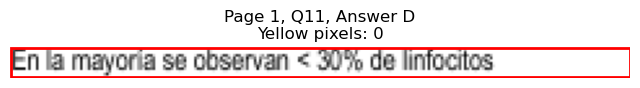


Page 1, Q11 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=68.3, y0=103.8, x1=88.8, y1=114.8
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 58
Page 2, Q1, A: Yellow percentage: 0.0%


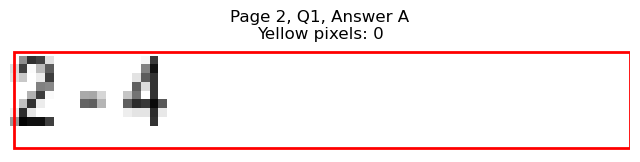

Page 2, Q1 - B: Detected box: x0=68.3, y0=116.4, x1=80.9, y1=127.4
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 51
Page 2, Q1, B: Yellow percentage: 0.0%


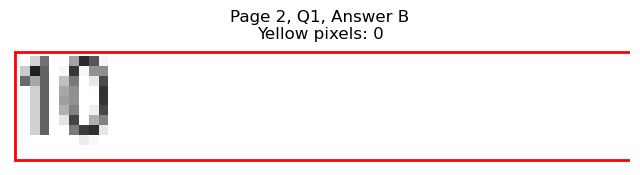

Page 2, Q1 - C: Detected box: x0=327.5, y0=103.8, x1=350.3, y1=114.8
Page 2, Q1, C: Yellow pixels: 829
Page 2, Q1, C: Total non-white pixels: 888
Page 2, Q1, C: Yellow percentage: 93.4%


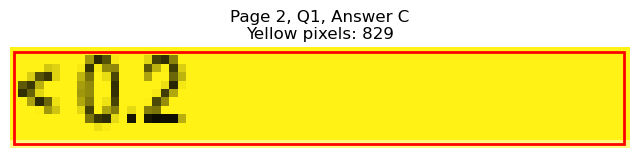

Page 2, Q1 - D: Detected box: x0=327.5, y0=116.4, x1=355.6, y1=127.4
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 100
Page 2, Q1, D: Yellow percentage: 0.0%


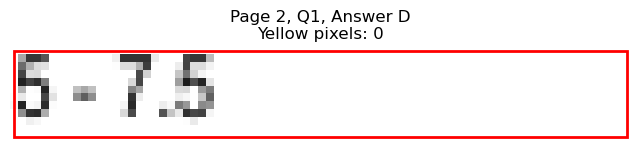


Page 2, Q1 - Selected Answer: C (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=56.6, y0=192.1, x1=65.2, y1=203.1
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 54
Page 2, Q2, A: Yellow percentage: 0.0%


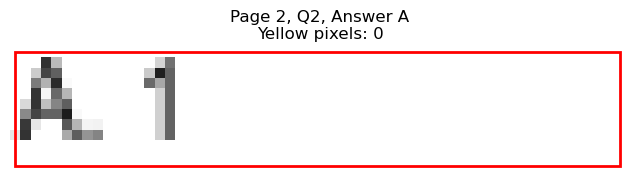

Page 2, Q2 - B: Detected box: x0=56.6, y0=204.7, x1=65.2, y1=215.7
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 73
Page 2, Q2, B: Yellow percentage: 0.0%


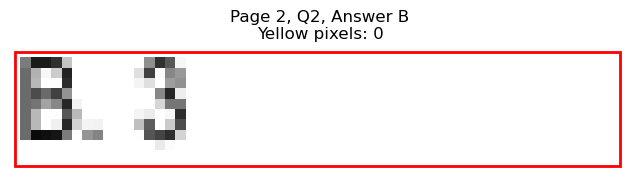

Page 2, Q2 - C: Detected box: x0=315.4, y0=192.1, x1=324.4, y1=203.1
Page 2, Q2, C: Yellow pixels: 60
Page 2, Q2, C: Total non-white pixels: 187
Page 2, Q2, C: Yellow percentage: 32.1%


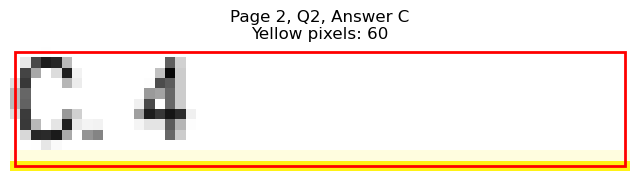

Page 2, Q2 - D: Detected box: x0=315.4, y0=204.7, x1=324.4, y1=215.7
Page 2, Q2, D: Yellow pixels: 675
Page 2, Q2, D: Total non-white pixels: 720
Page 2, Q2, D: Yellow percentage: 93.8%


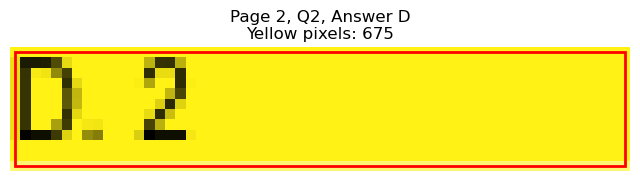


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=68.3, y0=255.2, x1=123.5, y1=266.2
Page 2, Q3, A: Yellow pixels: 963
Page 2, Q3, A: Total non-white pixels: 1166
Page 2, Q3, A: Yellow percentage: 82.6%


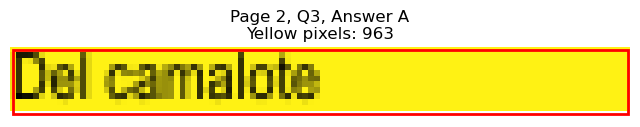

Page 2, Q3 - B: Detected box: x0=68.3, y0=267.8, x1=129.0, y1=278.8
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 297
Page 2, Q3, B: Yellow percentage: 0.0%


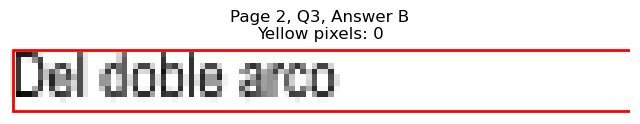

Page 2, Q3 - C: Detected box: x0=327.5, y0=255.2, x1=412.7, y1=266.2
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 450
Page 2, Q3, C: Yellow percentage: 0.0%


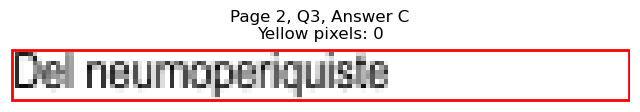

Page 2, Q3 - D: Detected box: x0=327.5, y0=267.8, x1=371.6, y1=278.8
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 216
Page 2, Q3, D: Yellow percentage: 0.0%


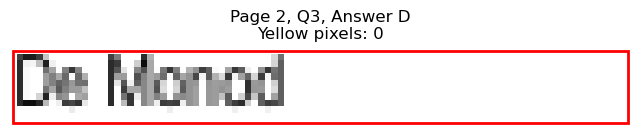


Page 2, Q3 - Selected Answer: A (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=68.3, y0=318.3, x1=192.1, y1=329.4
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 636
Page 2, Q4, A: Yellow percentage: 0.0%


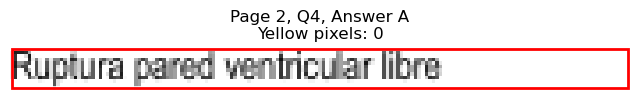

Page 2, Q4 - B: Detected box: x0=68.3, y0=330.9, x1=172.6, y1=342.0
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 519
Page 2, Q4, B: Yellow percentage: 0.0%


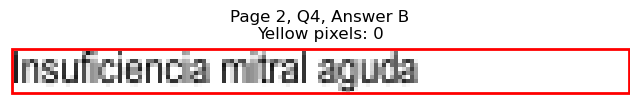

Page 2, Q4 - C: Detected box: x0=327.5, y0=318.3, x1=398.8, y1=329.4
Page 2, Q4, C: Yellow pixels: 122
Page 2, Q4, C: Total non-white pixels: 482
Page 2, Q4, C: Yellow percentage: 25.3%


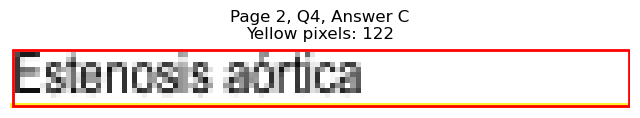

Page 2, Q4 - D: Detected box: x0=327.5, y0=330.9, x1=392.2, y1=342.0
Page 2, Q4, D: Yellow pixels: 1161
Page 2, Q4, D: Total non-white pixels: 1392
Page 2, Q4, D: Yellow percentage: 83.4%


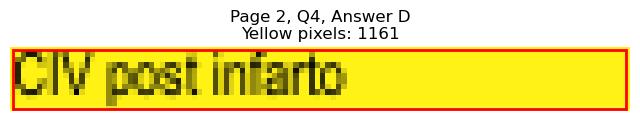


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=68.3, y0=368.8, x1=93.8, y1=379.9
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 131
Page 2, Q5, A: Yellow percentage: 0.0%


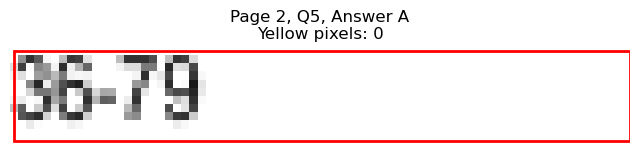

Page 2, Q5 - B: Detected box: x0=68.3, y0=381.4, x1=93.8, y1=392.5
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 117
Page 2, Q5, B: Yellow percentage: 0.0%


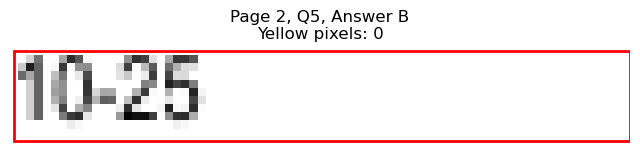

Page 2, Q5 - C: Detected box: x0=327.5, y0=368.8, x1=353.0, y1=379.9
Page 2, Q5, C: Yellow pixels: 853
Page 2, Q5, C: Total non-white pixels: 924
Page 2, Q5, C: Yellow percentage: 92.3%


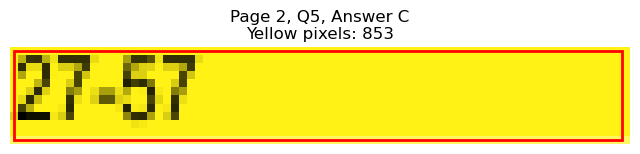

Page 2, Q5 - D: Detected box: x0=327.5, y0=381.4, x1=353.0, y1=392.5
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 136
Page 2, Q5, D: Yellow percentage: 0.0%


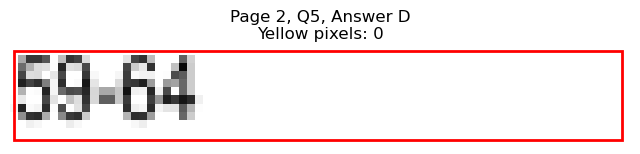


Page 2, Q5 - Selected Answer: C (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=146.5, y1=468.2
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 419
Page 2, Q6, A: Yellow percentage: 0.0%


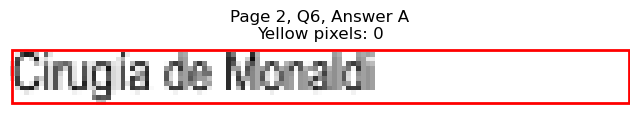

Page 2, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=182.2, y1=480.8
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 558
Page 2, Q6, B: Yellow percentage: 0.0%


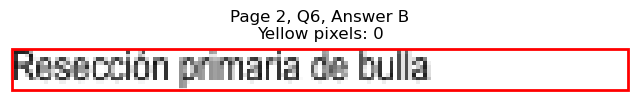

Page 2, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=425.3, y1=468.2
Page 2, Q6, C: Yellow pixels: 1253
Page 2, Q6, C: Total non-white pixels: 1644
Page 2, Q6, C: Yellow percentage: 76.2%


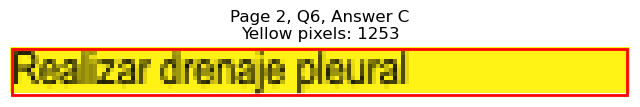

Page 2, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=447.4, y1=480.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 581
Page 2, Q6, D: Yellow percentage: 0.0%


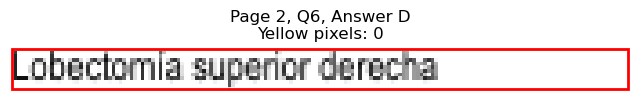


Page 2, Q6 - Selected Answer: C (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=121.9, y1=518.7
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 277
Page 2, Q7, A: Yellow percentage: 0.0%


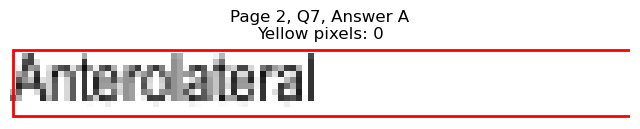

Page 2, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=93.4, y1=531.3
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 127
Page 2, Q7, B: Yellow percentage: 0.0%


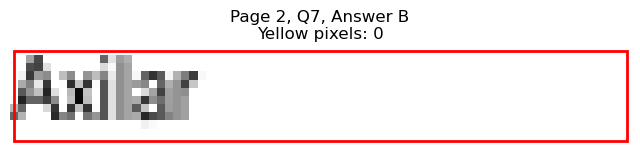

Page 2, Q7 - C: Detected box: x0=327.5, y0=507.7, x1=385.7, y1=518.7
Page 2, Q7, C: Yellow pixels: 1073
Page 2, Q7, C: Total non-white pixels: 1308
Page 2, Q7, C: Yellow percentage: 82.0%


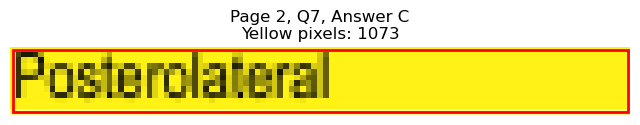

Page 2, Q7 - D: Detected box: x0=327.5, y0=520.3, x1=362.6, y1=531.3
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 185
Page 2, Q7, D: Yellow percentage: 0.0%


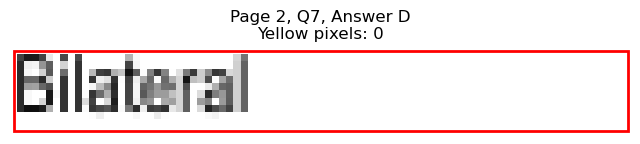


Page 2, Q7 - Selected Answer: C (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=68.3, y0=558.2, x1=115.4, y1=569.2
Page 2, Q8, A: Yellow pixels: 98
Page 2, Q8, A: Total non-white pixels: 353
Page 2, Q8, A: Yellow percentage: 27.8%


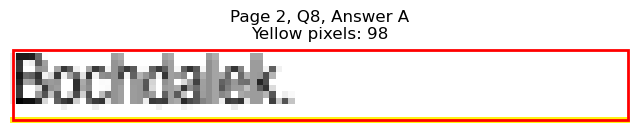

Page 2, Q8 - B: Detected box: x0=68.3, y0=570.8, x1=110.9, y1=581.8
Page 2, Q8, B: Yellow pixels: 927
Page 2, Q8, B: Total non-white pixels: 1116
Page 2, Q8, B: Yellow percentage: 83.1%


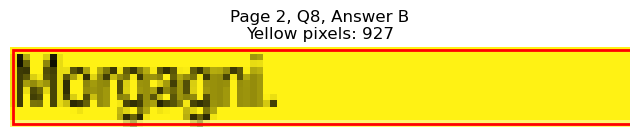

Page 2, Q8 - C: Detected box: x0=327.5, y0=558.2, x1=376.2, y1=569.2
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 238
Page 2, Q8, C: Yellow percentage: 0.0%


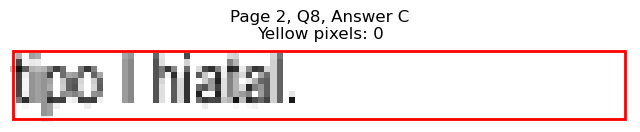

Page 2, Q8 - D: Detected box: x0=327.5, y0=570.8, x1=413.8, y1=581.8
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 458
Page 2, Q8, D: Yellow percentage: 0.0%


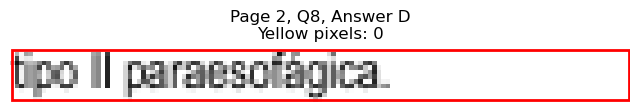


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=68.3, y0=633.9, x1=184.7, y1=645.0
Page 2, Q9, A: Yellow pixels: 1548
Page 2, Q9, A: Total non-white pixels: 2004
Page 2, Q9, A: Yellow percentage: 77.2%


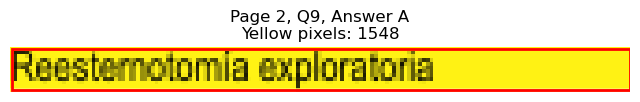

Page 2, Q9 - B: Detected box: x0=68.3, y0=646.5, x1=190.7, y1=657.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 622
Page 2, Q9, B: Yellow percentage: 0.0%


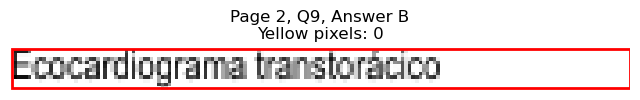

Page 2, Q9 - C: Detected box: x0=327.5, y0=633.9, x1=415.2, y1=645.0
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 455
Page 2, Q9, C: Yellow percentage: 0.0%


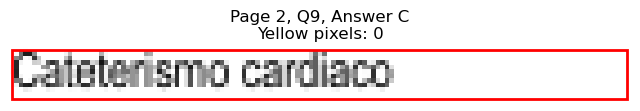

Page 2, Q9 - D: Detected box: x0=327.5, y0=646.5, x1=457.3, y1=657.6
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 622
Page 2, Q9, D: Yellow percentage: 0.0%


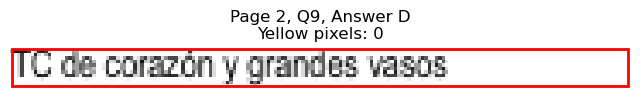


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=161.0, y1=695.4
Page 2, Q10, A: Yellow pixels: 144
Page 2, Q10, A: Total non-white pixels: 640
Page 2, Q10, A: Yellow percentage: 22.5%


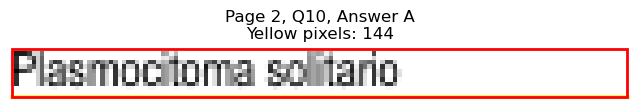

Page 2, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=183.6, y1=708.1
Page 2, Q10, B: Yellow pixels: 1375
Page 2, Q10, B: Total non-white pixels: 1829
Page 2, Q10, B: Yellow percentage: 75.2%


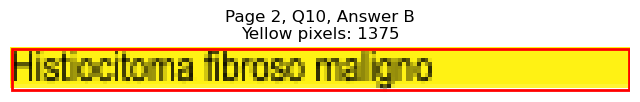

Page 2, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=393.1, y1=695.4
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 310
Page 2, Q10, C: Yellow percentage: 0.0%


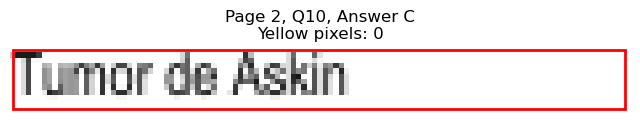

Page 2, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=359.6, y1=708.1
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 145
Page 2, Q10, D: Yellow percentage: 0.0%


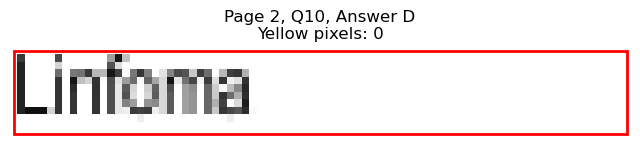


Page 2, Q10 - Selected Answer: B (based on yellow pixel count)





Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=262.0, y1=102.2
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 1191
Page 3, Q1, A: Yellow percentage: 0.0%


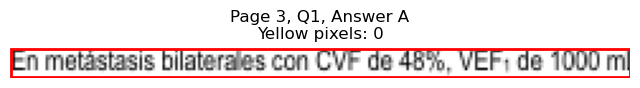

Page 3, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=331.7, y1=114.8
Page 3, Q1, B: Yellow pixels: 314
Page 3, Q1, B: Total non-white pixels: 1709
Page 3, Q1, B: Yellow percentage: 18.4%


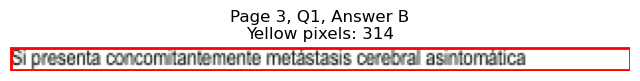

Page 3, Q1 - C: Detected box: x0=68.8, y0=116.4, x1=329.2, y1=127.4
Page 3, Q1, C: Yellow pixels: 2398
Page 3, Q1, C: Total non-white pixels: 3744
Page 3, Q1, C: Yellow percentage: 64.0%


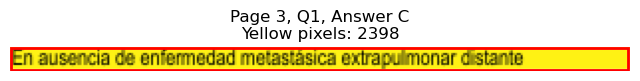

Page 3, Q1 - D: Detected box: x0=68.8, y0=129.0, x1=298.0, y1=140.0
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 1179
Page 3, Q1, D: Yellow percentage: 0.0%


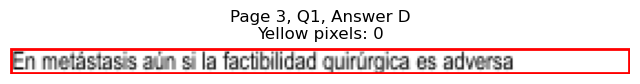


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=251.4, y1=190.5
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 832
Page 3, Q2, A: Yellow percentage: 0.0%


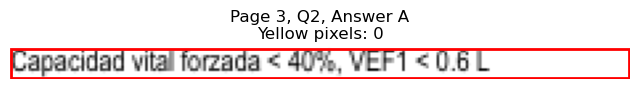

Page 3, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=301.6, y1=203.1
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 1186
Page 3, Q2, B: Yellow percentage: 0.0%


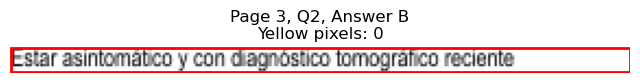

Page 3, Q2 - C: Detected box: x0=68.8, y0=204.7, x1=313.0, y1=215.7
Page 3, Q2, C: Yellow pixels: 4
Page 3, Q2, C: Total non-white pixels: 1516
Page 3, Q2, C: Yellow percentage: 0.3%


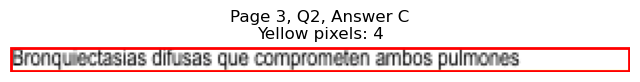

Page 3, Q2 - D: Detected box: x0=68.8, y0=217.4, x1=368.0, y1=228.4
Page 3, Q2, D: Yellow pixels: 2726
Page 3, Q2, D: Total non-white pixels: 4212
Page 3, Q2, D: Yellow percentage: 64.7%


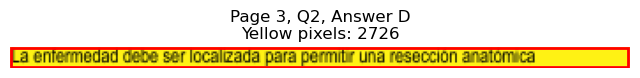


Page 3, Q2 - Selected Answer: D (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=468.0, y1=304.2
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 2060
Page 3, Q3, A: Yellow percentage: 0.0%


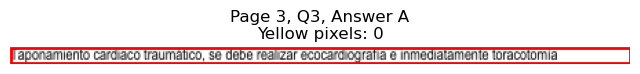

Page 3, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=469.3, y1=316.8
Page 3, Q3, B: Yellow pixels: 452
Page 3, Q3, B: Total non-white pixels: 2429
Page 3, Q3, B: Yellow percentage: 18.6%


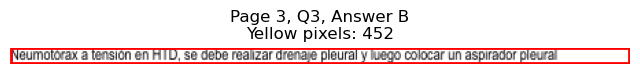

Page 3, Q3 - C: Detected box: x0=68.8, y0=318.3, x1=486.1, y1=329.4
Page 3, Q3, C: Yellow pixels: 3531
Page 3, Q3, C: Total non-white pixels: 5628
Page 3, Q3, C: Yellow percentage: 62.7%


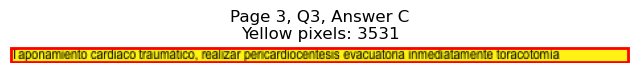

Page 3, Q3 - D: Detected box: x0=68.8, y0=330.9, x1=491.0, y1=342.0
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 2011
Page 3, Q3, D: Yellow percentage: 0.0%


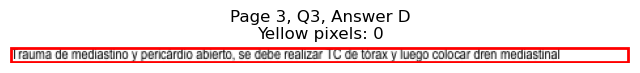


Page 3, Q3 - Selected Answer: C (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=68.3, y0=368.8, x1=159.1, y1=379.9
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 455
Page 3, Q4, A: Yellow percentage: 0.0%


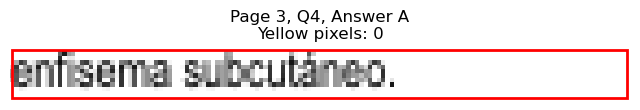

Page 3, Q4 - B: Detected box: x0=68.3, y0=381.4, x1=183.6, y1=392.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 575
Page 3, Q4, B: Yellow percentage: 0.0%


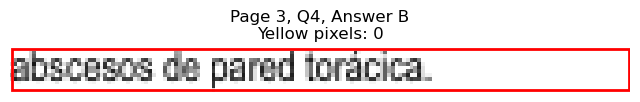

Page 3, Q4 - C: Detected box: x0=327.5, y0=368.8, x1=466.4, y1=379.9
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 850
Page 3, Q4, C: Yellow percentage: 0.0%


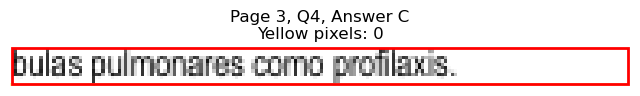

Page 3, Q4 - D: Detected box: x0=327.5, y0=381.4, x1=364.6, y1=392.5
Page 3, Q4, D: Yellow pixels: 841
Page 3, Q4, D: Total non-white pixels: 1056
Page 3, Q4, D: Yellow percentage: 79.6%


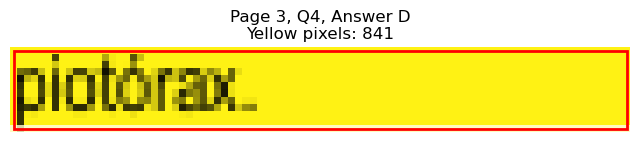


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=68.3, y0=444.6, x1=160.6, y1=455.6
Page 3, Q5, A: Yellow pixels: 1195
Page 3, Q5, A: Total non-white pixels: 1716
Page 3, Q5, A: Yellow percentage: 69.6%


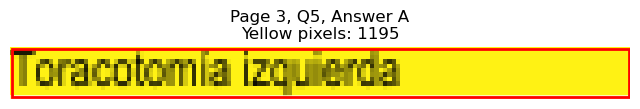

Page 3, Q5 - B: Detected box: x0=68.3, y0=457.2, x1=132.5, y1=468.2
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 346
Page 3, Q5, B: Yellow percentage: 0.0%


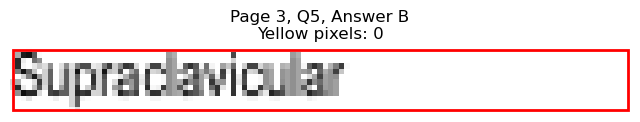

Page 3, Q5 - C: Detected box: x0=327.5, y0=444.6, x1=385.7, y1=455.6
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 308
Page 3, Q5, C: Yellow percentage: 0.0%


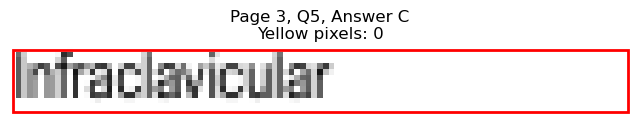

Page 3, Q5 - D: Detected box: x0=327.5, y0=457.2, x1=410.8, y1=468.2
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 416
Page 3, Q5, D: Yellow percentage: 0.0%


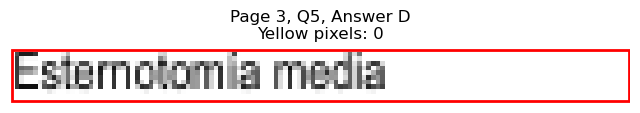


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=131.0, y1=531.3
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 282
Page 3, Q6, A: Yellow percentage: 0.0%


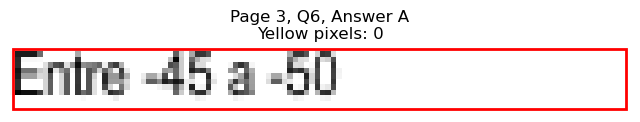

Page 3, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=121.1, y1=543.9
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 220
Page 3, Q6, B: Yellow percentage: 0.0%


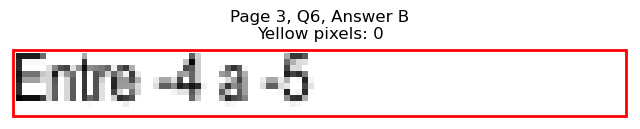

Page 3, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=390.2, y1=531.3
Page 3, Q6, C: Yellow pixels: 1056
Page 3, Q6, C: Total non-white pixels: 1368
Page 3, Q6, C: Yellow percentage: 77.2%


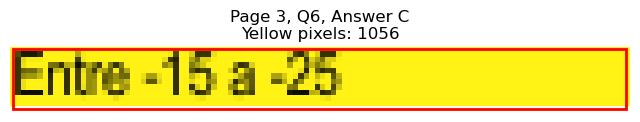

Page 3, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=389.8, y1=543.9
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 254
Page 3, Q6, D: Yellow percentage: 0.0%


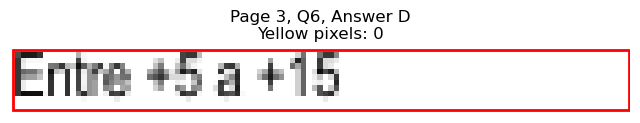


Page 3, Q6 - Selected Answer: C (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=68.3, y0=570.8, x1=130.4, y1=581.8
Page 3, Q7, A: Yellow pixels: 1
Page 3, Q7, A: Total non-white pixels: 365
Page 3, Q7, A: Yellow percentage: 0.3%


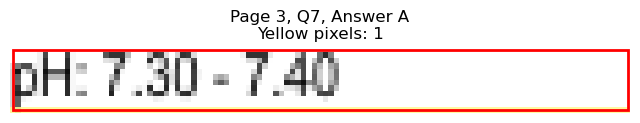

Page 3, Q7 - B: Detected box: x0=68.3, y0=583.4, x1=161.5, y1=594.4
Page 3, Q7, B: Yellow pixels: 1260
Page 3, Q7, B: Total non-white pixels: 1728
Page 3, Q7, B: Yellow percentage: 72.9%


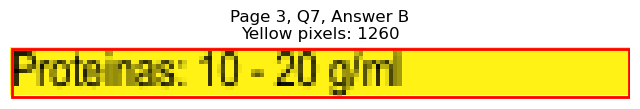

Page 3, Q7 - C: Detected box: x0=327.5, y0=570.8, x1=460.3, y1=581.8
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 672
Page 3, Q7, C: Yellow percentage: 0.0%


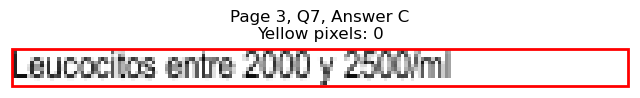

Page 3, Q7 - D: Detected box: x0=327.5, y0=583.4, x1=438.6, y1=594.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 502
Page 3, Q7, D: Yellow percentage: 0.0%


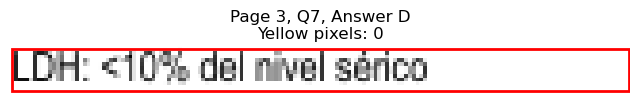


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=68.3, y0=646.5, x1=151.6, y1=657.6
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 427
Page 3, Q8, A: Yellow percentage: 0.0%


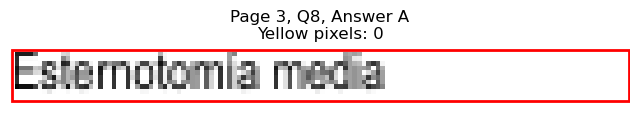

Page 3, Q8 - B: Detected box: x0=68.3, y0=659.1, x1=144.5, y1=670.2
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 407
Page 3, Q8, B: Yellow percentage: 0.0%


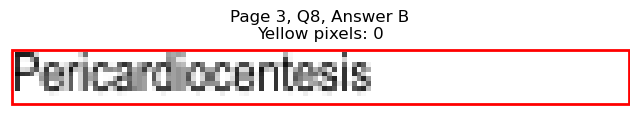

Page 3, Q8 - C: Detected box: x0=327.5, y0=646.5, x1=458.4, y1=657.6
Page 3, Q8, C: Yellow pixels: 182
Page 3, Q8, C: Total non-white pixels: 878
Page 3, Q8, C: Yellow percentage: 20.7%


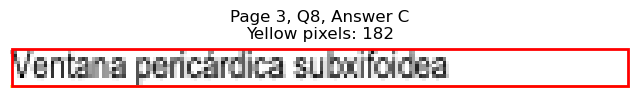

Page 3, Q8 - D: Detected box: x0=327.5, y0=659.1, x1=472.4, y1=670.2
Page 3, Q8, D: Yellow pixels: 1556
Page 3, Q8, D: Total non-white pixels: 2158
Page 3, Q8, D: Yellow percentage: 72.1%


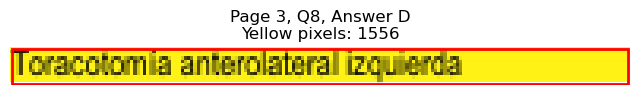


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=68.3, y0=722.2, x1=375.2, y1=733.3
Page 3, Q9, A: Yellow pixels: 2792
Page 3, Q9, A: Total non-white pixels: 4296
Page 3, Q9, A: Yellow percentage: 65.0%


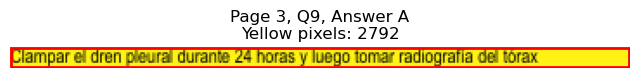

Page 3, Q9 - B: Detected box: x0=68.3, y0=734.8, x1=203.6, y1=745.9
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 725
Page 3, Q9, B: Yellow percentage: 0.0%


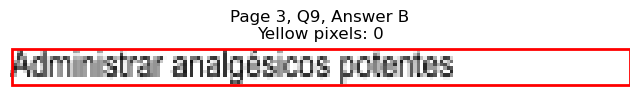

Page 3, Q9 - C: Detected box: x0=68.8, y0=747.4, x1=330.6, y1=758.5
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 1273
Page 3, Q9, C: Yellow percentage: 0.0%


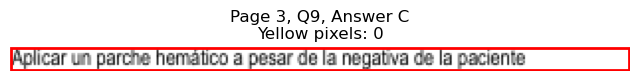

Page 3, Q9 - D: Detected box: x0=68.8, y0=760.2, x1=257.3, y1=771.2
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 926
Page 3, Q9, D: Yellow percentage: 0.0%


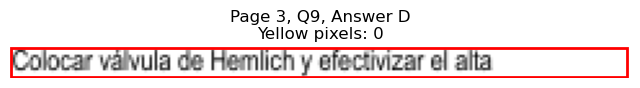


Page 3, Q9 - Selected Answer: A (based on yellow pixel count)





Page 4: Found 11 questions
Page 4, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=155.5, y1=102.2
Page 4, Q1, A: Yellow pixels: 1158
Page 4, Q1, A: Total non-white pixels: 1522
Page 4, Q1, A: Yellow percentage: 76.1%


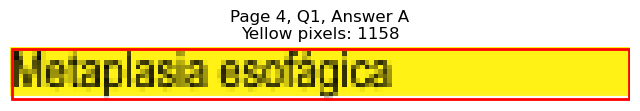

Page 4, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=104.9, y1=114.8
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 189
Page 4, Q1, B: Yellow percentage: 0.0%


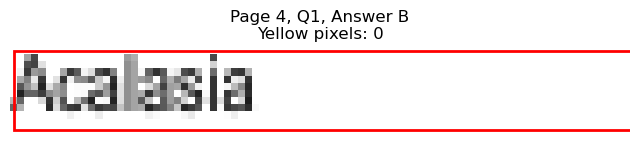

Page 4, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=423.2, y1=102.2
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 518
Page 4, Q1, C: Yellow percentage: 0.0%


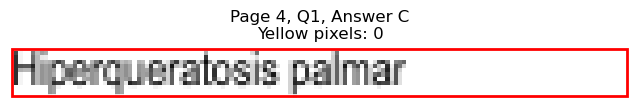

Page 4, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=404.8, y1=114.8
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 422
Page 4, Q1, D: Yellow percentage: 0.0%


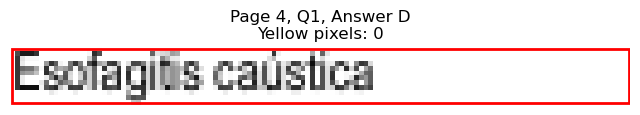


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=107.9, y1=152.7
Page 4, Q2, A: Yellow pixels: 90
Page 4, Q2, A: Total non-white pixels: 300
Page 4, Q2, A: Yellow percentage: 30.0%


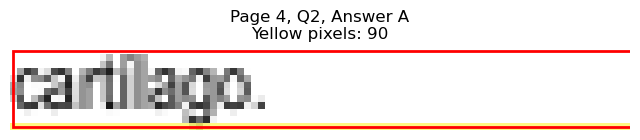

Page 4, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=117.0, y1=165.3
Page 4, Q2, B: Yellow pixels: 904
Page 4, Q2, B: Total non-white pixels: 1188
Page 4, Q2, B: Yellow percentage: 76.1%


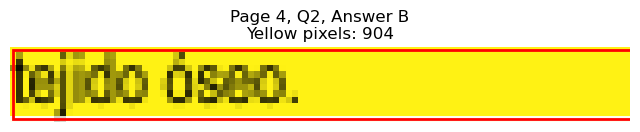

Page 4, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=393.1, y1=152.7
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 333
Page 4, Q2, C: Yellow percentage: 0.0%


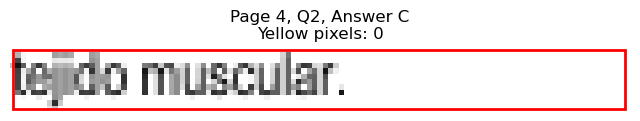

Page 4, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=394.7, y1=165.3
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 348
Page 4, Q2, D: Yellow percentage: 0.0%


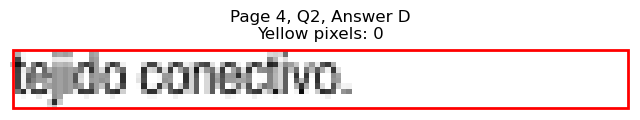


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=68.3, y0=192.1, x1=122.4, y1=203.1
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 240
Page 4, Q3, A: Yellow percentage: 0.0%


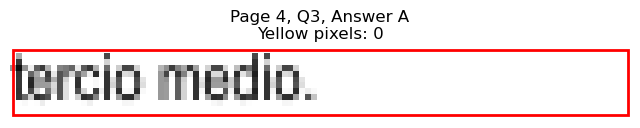

Page 4, Q3 - B: Detected box: x0=68.3, y0=204.7, x1=159.1, y1=215.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 472
Page 4, Q3, B: Yellow percentage: 0.0%


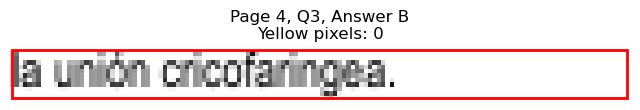

Page 4, Q3 - C: Detected box: x0=327.5, y0=192.1, x1=391.2, y1=203.1
Page 4, Q3, C: Yellow pixels: 115
Page 4, Q3, C: Total non-white pixels: 531
Page 4, Q3, C: Yellow percentage: 21.7%


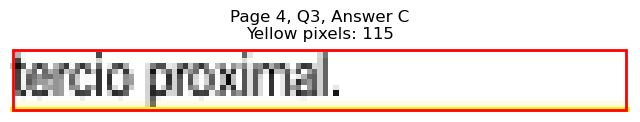

Page 4, Q3 - D: Detected box: x0=327.5, y0=204.7, x1=378.1, y1=215.7
Page 4, Q3, D: Yellow pixels: 1020
Page 4, Q3, D: Total non-white pixels: 1224
Page 4, Q3, D: Yellow percentage: 83.3%


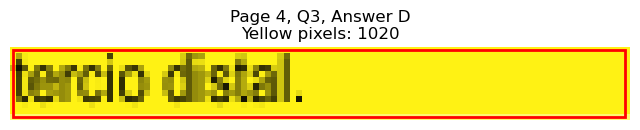


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=68.3, y0=267.8, x1=361.2, y1=278.8
Page 4, Q4, A: Yellow pixels: 3066
Page 4, Q4, A: Total non-white pixels: 4128
Page 4, Q4, A: Yellow percentage: 74.3%


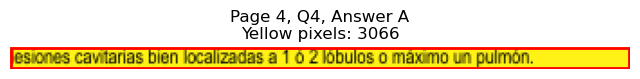

Page 4, Q4 - B: Detected box: x0=68.3, y0=280.5, x1=316.6, y1=291.6
Page 4, Q4, B: Yellow pixels: 0
Page 4, Q4, B: Total non-white pixels: 1190
Page 4, Q4, B: Yellow percentage: 0.0%


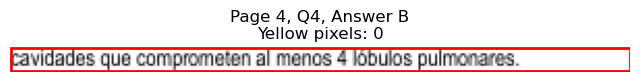

Page 4, Q4 - C: Detected box: x0=68.8, y0=293.1, x1=352.7, y1=304.2
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 1397
Page 4, Q4, C: Yellow percentage: 0.0%


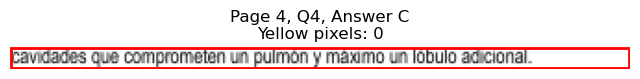

Page 4, Q4 - D: Detected box: x0=68.8, y0=305.7, x1=177.1, y1=316.8
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 552
Page 4, Q4, D: Yellow percentage: 0.0%


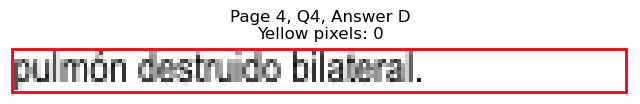


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=80.9, y1=367.3
Page 4, Q5, A: Yellow pixels: 647
Page 4, Q5, A: Total non-white pixels: 756
Page 4, Q5, A: Yellow percentage: 85.6%


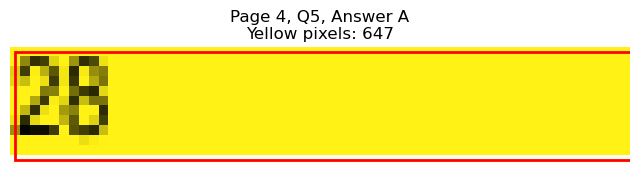

Page 4, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=80.9, y1=379.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 42
Page 4, Q5, B: Yellow percentage: 0.0%


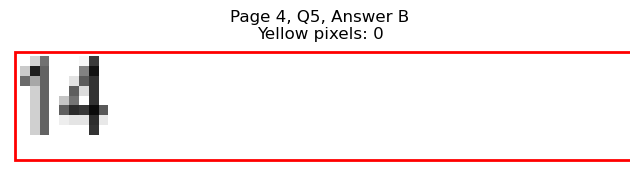

Page 4, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=340.1, y1=367.3
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 66
Page 4, Q5, C: Yellow percentage: 0.0%


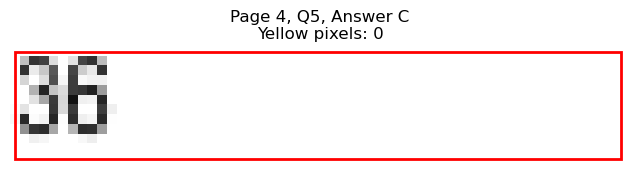

Page 4, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=340.1, y1=379.9
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 63
Page 4, Q5, D: Yellow percentage: 0.0%


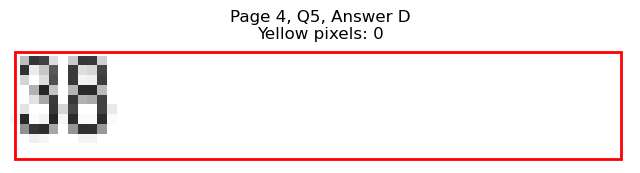


Page 4, Q5 - Selected Answer: A (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=68.3, y0=432.0, x1=134.0, y1=443.0
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 432
Page 4, Q6, A: Yellow percentage: 0.0%


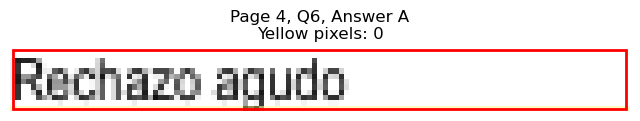

Page 4, Q6 - B: Detected box: x0=68.3, y0=444.6, x1=163.1, y1=455.6
Page 4, Q6, B: Yellow pixels: 1279
Page 4, Q6, B: Total non-white pixels: 1752
Page 4, Q6, B: Yellow percentage: 73.0%


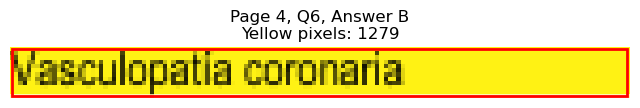

Page 4, Q6 - C: Detected box: x0=327.5, y0=432.0, x1=362.0, y1=443.0
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 145
Page 4, Q6, C: Yellow percentage: 0.0%


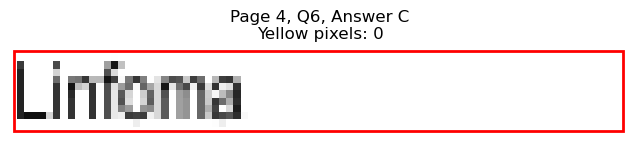

Page 4, Q6 - D: Detected box: x0=327.5, y0=444.6, x1=371.6, y1=455.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 223
Page 4, Q6, D: Yellow percentage: 0.0%


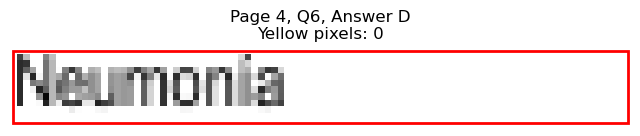


Page 4, Q6 - Selected Answer: B (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=68.3, y0=482.5, x1=205.2, y1=493.5
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 685
Page 4, Q7, A: Yellow percentage: 0.0%


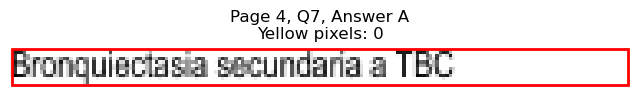

Page 4, Q7 - B: Detected box: x0=68.3, y0=495.1, x1=145.0, y1=506.1
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 387
Page 4, Q7, B: Yellow percentage: 0.0%


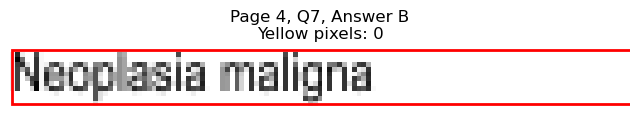

Page 4, Q7 - C: Detected box: x0=327.5, y0=482.5, x1=496.9, y1=493.5
Page 4, Q7, C: Yellow pixels: 1693
Page 4, Q7, C: Total non-white pixels: 2556
Page 4, Q7, C: Yellow percentage: 66.2%


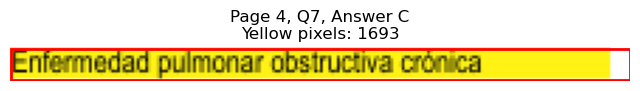

Page 4, Q7 - D: Detected box: x0=327.5, y0=495.1, x1=382.2, y1=506.1
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 308
Page 4, Q7, D: Yellow percentage: 0.0%


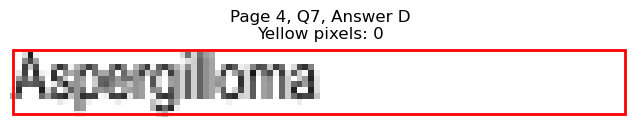


Page 4, Q7 - Selected Answer: C (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=113.4, y1=556.5
Page 4, Q8, A: Yellow pixels: 96
Page 4, Q8, A: Total non-white pixels: 340
Page 4, Q8, A: Yellow percentage: 28.2%


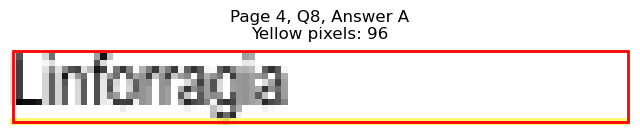

Page 4, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=176.2, y1=569.2
Page 4, Q8, B: Yellow pixels: 1298
Page 4, Q8, B: Total non-white pixels: 1749
Page 4, Q8, B: Yellow percentage: 74.2%


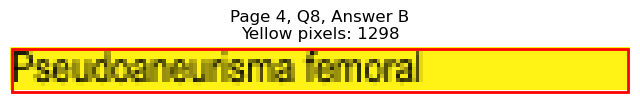

Page 4, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=414.2, y1=556.5
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 440
Page 4, Q8, C: Yellow percentage: 0.0%


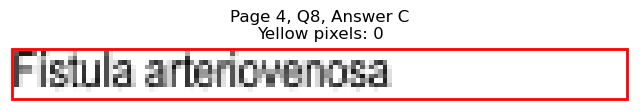

Page 4, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=404.6, y1=569.2
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 372
Page 4, Q8, D: Yellow percentage: 0.0%


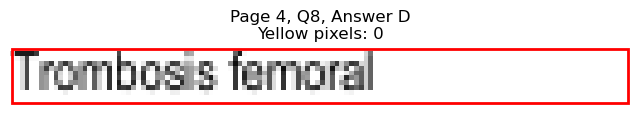


Page 4, Q8 - Selected Answer: B (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=146.0, y1=619.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 397
Page 4, Q9, A: Yellow percentage: 0.0%


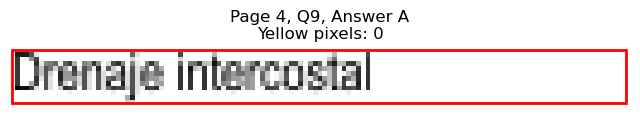

Page 4, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=171.1, y1=632.4
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 536
Page 4, Q9, B: Yellow percentage: 0.0%


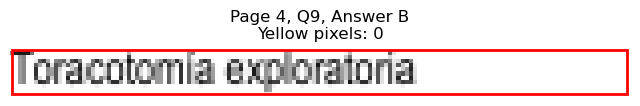

Page 4, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=434.3, y1=619.6
Page 4, Q9, C: Yellow pixels: 1499
Page 4, Q9, C: Total non-white pixels: 1896
Page 4, Q9, C: Yellow percentage: 79.1%


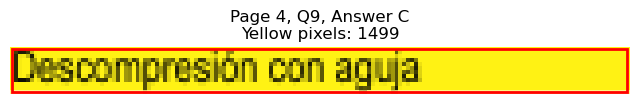

Page 4, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=395.2, y1=632.4
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 345
Page 4, Q9, D: Yellow percentage: 0.0%


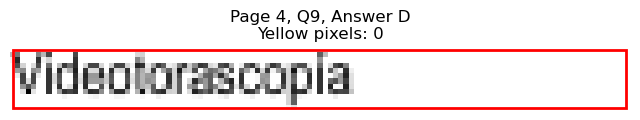


Page 4, Q9 - Selected Answer: C (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=68.3, y0=659.1, x1=163.1, y1=670.2
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 486
Page 4, Q10, A: Yellow percentage: 0.0%


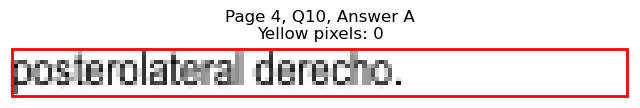

Page 4, Q10 - B: Detected box: x0=68.3, y0=671.7, x1=157.1, y1=682.8
Page 4, Q10, B: Yellow pixels: 0
Page 4, Q10, B: Total non-white pixels: 442
Page 4, Q10, B: Yellow percentage: 0.0%


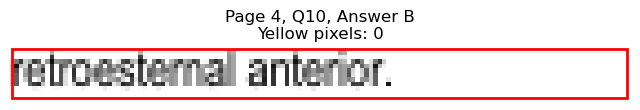

Page 4, Q10 - C: Detected box: x0=327.5, y0=659.1, x1=426.2, y1=670.2
Page 4, Q10, C: Yellow pixels: 1264
Page 4, Q10, C: Total non-white pixels: 1653
Page 4, Q10, C: Yellow percentage: 76.5%


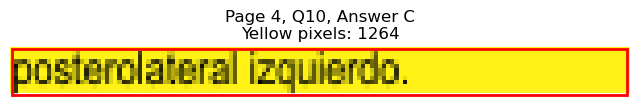

Page 4, Q10 - D: Detected box: x0=327.5, y0=671.7, x1=389.2, y1=682.8
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 313
Page 4, Q10, D: Yellow percentage: 0.0%


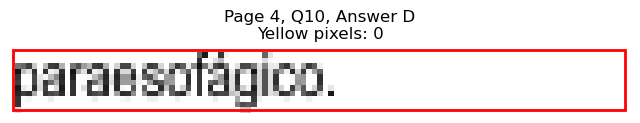


Page 4, Q10 - Selected Answer: C (based on yellow pixel count)




Page 4, Q11 - A: Detected box: x0=68.3, y0=722.2, x1=168.1, y1=733.3
Page 4, Q11, A: Yellow pixels: 0
Page 4, Q11, A: Total non-white pixels: 539
Page 4, Q11, A: Yellow percentage: 0.0%


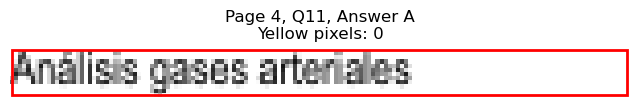

Page 4, Q11 - B: Detected box: x0=68.3, y0=734.8, x1=105.5, y1=745.9
Page 4, Q11, B: Yellow pixels: 0
Page 4, Q11, B: Total non-white pixels: 169
Page 4, Q11, B: Yellow percentage: 0.0%


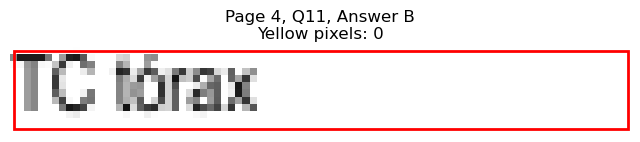

Page 4, Q11 - C: Detected box: x0=327.5, y0=722.2, x1=430.8, y1=733.3
Page 4, Q11, C: Yellow pixels: 154
Page 4, Q11, C: Total non-white pixels: 643
Page 4, Q11, C: Yellow percentage: 24.0%


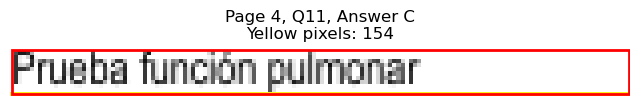

Page 4, Q11 - D: Detected box: x0=327.5, y0=734.8, x1=482.9, y1=745.9
Page 4, Q11, D: Yellow pixels: 1908
Page 4, Q11, D: Total non-white pixels: 2472
Page 4, Q11, D: Yellow percentage: 77.2%


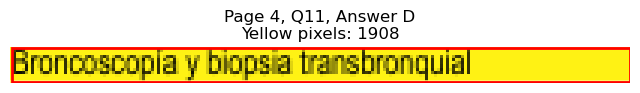


Page 4, Q11 - Selected Answer: D (based on yellow pixel count)





Page 5: Found 11 questions
Page 5, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=199.7, y1=102.2
Page 5, Q1, A: Yellow pixels: 182
Page 5, Q1, A: Total non-white pixels: 1013
Page 5, Q1, A: Yellow percentage: 18.0%


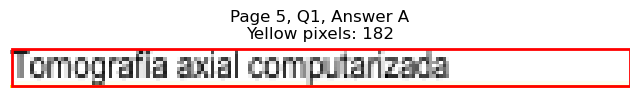

Page 5, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=126.0, y1=114.8
Page 5, Q1, B: Yellow pixels: 1081
Page 5, Q1, B: Total non-white pixels: 1296
Page 5, Q1, B: Yellow percentage: 83.4%


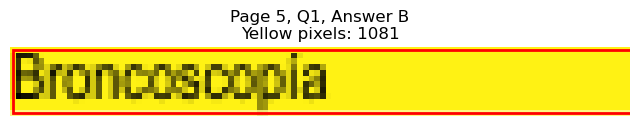

Page 5, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=440.3, y1=102.2
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 598
Page 5, Q1, C: Yellow percentage: 0.0%


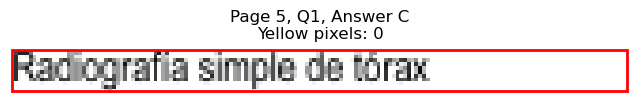

Page 5, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=401.8, y1=114.8
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 384
Page 5, Q1, D: Yellow percentage: 0.0%


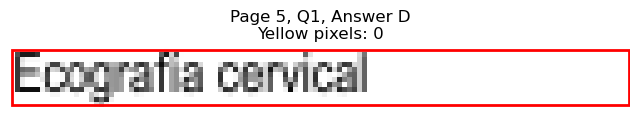


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=68.3, y0=166.9, x1=112.4, y1=177.9
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 221
Page 5, Q2, A: Yellow percentage: 0.0%


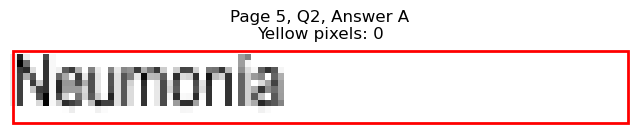

Page 5, Q2 - B: Detected box: x0=68.3, y0=179.5, x1=144.0, y1=190.5
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 403
Page 5, Q2, B: Yellow percentage: 0.0%


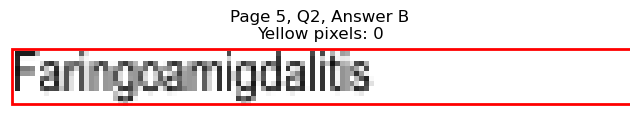

Page 5, Q2 - C: Detected box: x0=327.5, y0=166.9, x1=379.7, y1=177.9
Page 5, Q2, C: Yellow pixels: 1003
Page 5, Q2, C: Total non-white pixels: 1236
Page 5, Q2, C: Yellow percentage: 81.1%


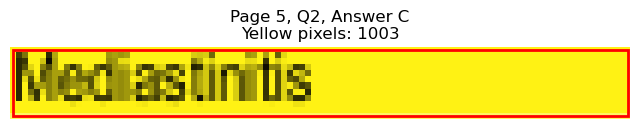

Page 5, Q2 - D: Detected box: x0=327.5, y0=179.5, x1=396.7, y1=190.5
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 347
Page 5, Q2, D: Yellow percentage: 0.0%


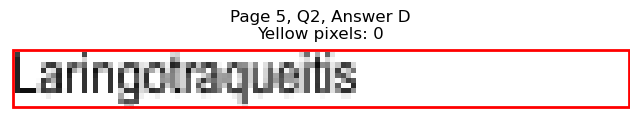


Page 5, Q2 - Selected Answer: C (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=115.9, y1=241.0
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 256
Page 5, Q3, A: Yellow percentage: 0.0%


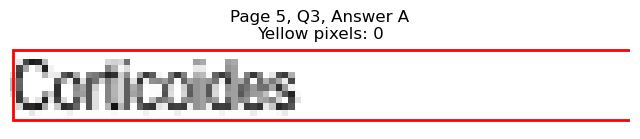

Page 5, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=140.0, y1=253.6
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 337
Page 5, Q3, B: Yellow percentage: 0.0%


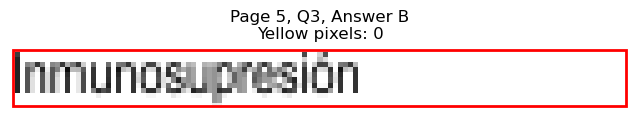

Page 5, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=376.1, y1=241.0
Page 5, Q3, C: Yellow pixels: 100
Page 5, Q3, C: Total non-white pixels: 446
Page 5, Q3, C: Yellow percentage: 22.4%


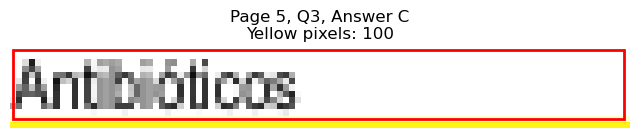

Page 5, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=386.2, y1=253.6
Page 5, Q3, D: Yellow pixels: 980
Page 5, Q3, D: Total non-white pixels: 1320
Page 5, Q3, D: Yellow percentage: 74.2%


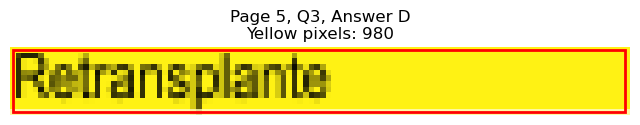


Page 5, Q3 - Selected Answer: D (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=127.4, y1=304.2
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 317
Page 5, Q4, A: Yellow percentage: 0.0%


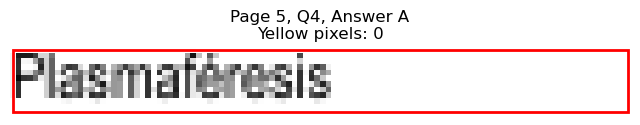

Page 5, Q4 - B: Detected box: x0=68.3, y0=242.6, x1=140.0, y1=253.6
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 337
Page 5, Q4, B: Yellow percentage: 0.0%


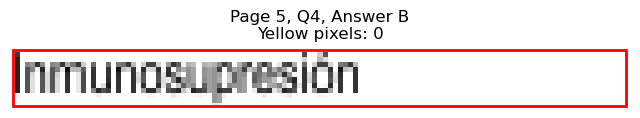

Page 5, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=377.2, y1=304.2
Page 5, Q4, C: Yellow pixels: 938
Page 5, Q4, C: Total non-white pixels: 1111
Page 5, Q4, C: Yellow percentage: 84.4%


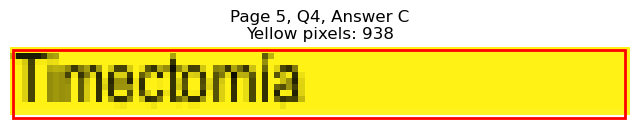

Page 5, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=451.9, y1=316.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 663
Page 5, Q4, D: Yellow percentage: 0.0%


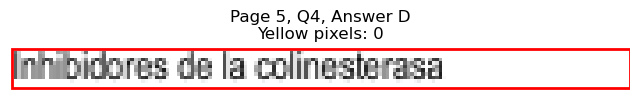


Page 5, Q4 - Selected Answer: C (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=96.4, y1=367.3
Page 5, Q5, A: Yellow pixels: 79
Page 5, Q5, A: Total non-white pixels: 228
Page 5, Q5, A: Yellow percentage: 34.6%


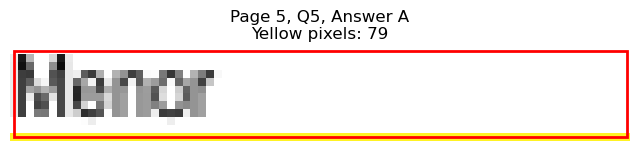

Page 5, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=99.4, y1=379.9
Page 5, Q5, B: Yellow pixels: 862
Page 5, Q5, B: Total non-white pixels: 984
Page 5, Q5, B: Yellow percentage: 87.6%


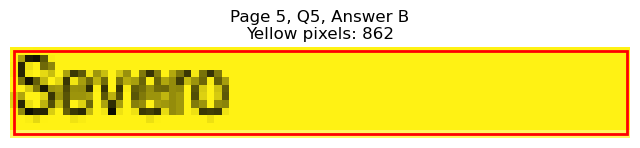

Page 5, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=370.6, y1=367.3
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 230
Page 5, Q5, C: Yellow percentage: 0.0%


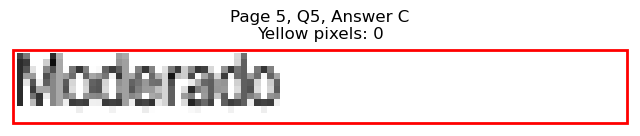

Page 5, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=376.7, y1=379.9
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 241
Page 5, Q5, D: Yellow percentage: 0.0%


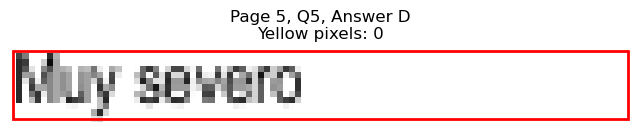


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=68.3, y0=419.4, x1=106.9, y1=430.4
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 184
Page 5, Q6, A: Yellow percentage: 0.0%


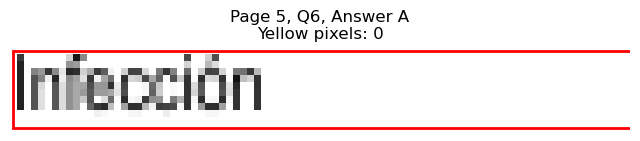

Page 5, Q6 - B: Detected box: x0=68.3, y0=432.0, x1=118.0, y1=443.0
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 236
Page 5, Q6, B: Yellow percentage: 0.0%


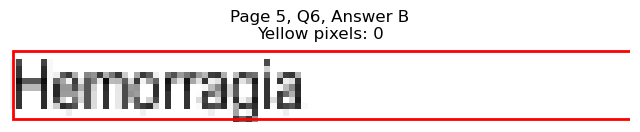

Page 5, Q6 - C: Detected box: x0=327.5, y0=419.4, x1=428.3, y1=430.4
Page 5, Q6, C: Yellow pixels: 152
Page 5, Q6, C: Total non-white pixels: 664
Page 5, Q6, C: Yellow percentage: 22.9%


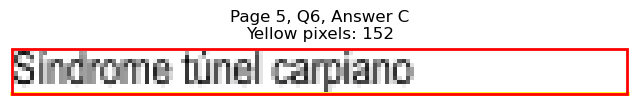

Page 5, Q6 - D: Detected box: x0=327.5, y0=432.0, x1=403.7, y1=443.0
Page 5, Q6, D: Yellow pixels: 1264
Page 5, Q6, D: Total non-white pixels: 1524
Page 5, Q6, D: Yellow percentage: 82.9%


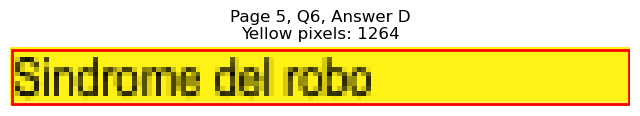


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=68.3, y0=469.8, x1=181.7, y1=480.8
Page 5, Q7, A: Yellow pixels: 1525
Page 5, Q7, A: Total non-white pixels: 1968
Page 5, Q7, A: Yellow percentage: 77.5%


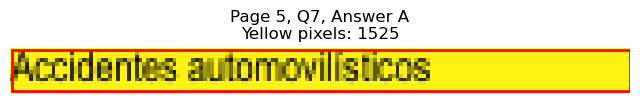

Page 5, Q7 - B: Detected box: x0=68.3, y0=482.5, x1=172.1, y1=493.5
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 512
Page 5, Q7, B: Yellow percentage: 0.0%


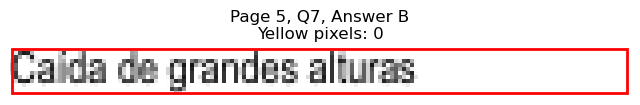

Page 5, Q7 - C: Detected box: x0=327.5, y0=469.8, x1=444.8, y1=480.8
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 623
Page 5, Q7, C: Yellow percentage: 0.0%


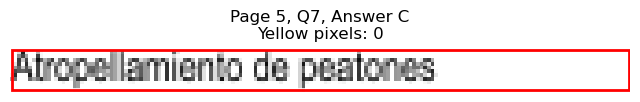

Page 5, Q7 - D: Detected box: x0=327.5, y0=482.5, x1=418.3, y1=493.5
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 463
Page 5, Q7, D: Yellow percentage: 0.0%


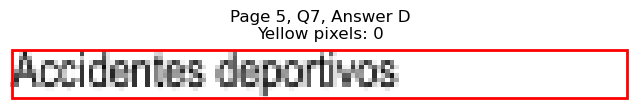


Page 5, Q7 - Selected Answer: A (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=68.3, y0=545.5, x1=145.6, y1=556.5
Page 5, Q8, A: Yellow pixels: 1098
Page 5, Q8, A: Total non-white pixels: 1536
Page 5, Q8, A: Yellow percentage: 71.5%


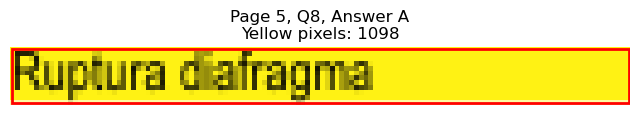

Page 5, Q8 - B: Detected box: x0=68.3, y0=558.2, x1=118.4, y1=569.2
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 261
Page 5, Q8, B: Yellow percentage: 0.0%


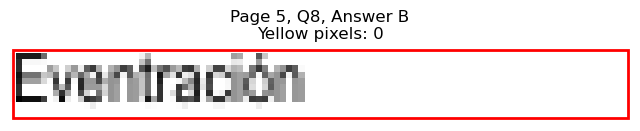

Page 5, Q8 - C: Detected box: x0=327.5, y0=545.5, x1=405.2, y1=556.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 387
Page 5, Q8, C: Yellow percentage: 0.0%


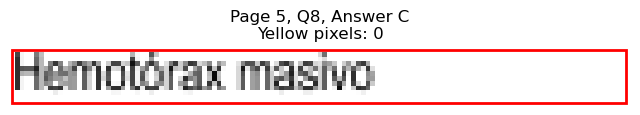

Page 5, Q8 - D: Detected box: x0=327.5, y0=558.2, x1=418.2, y1=569.2
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 466
Page 5, Q8, D: Yellow percentage: 0.0%


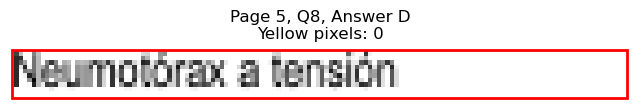


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=186.6, y1=607.0
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 602
Page 5, Q9, A: Yellow percentage: 0.0%


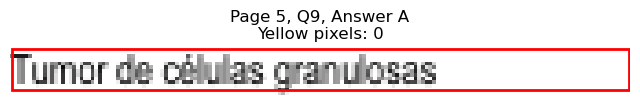

Page 5, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=152.0, y1=619.6
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 426
Page 5, Q9, B: Yellow percentage: 0.0%


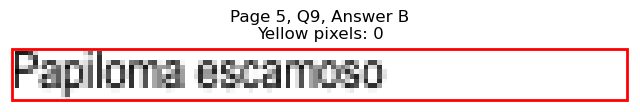

Page 5, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=372.1, y1=607.0
Page 5, Q9, C: Yellow pixels: 977
Page 5, Q9, C: Total non-white pixels: 1152
Page 5, Q9, C: Yellow percentage: 84.8%


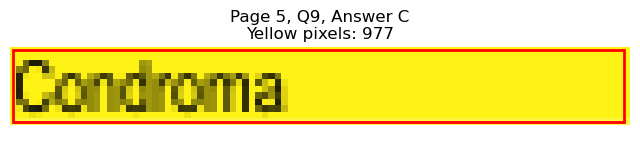

Page 5, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=384.6, y1=619.6
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 289
Page 5, Q9, D: Yellow percentage: 0.0%


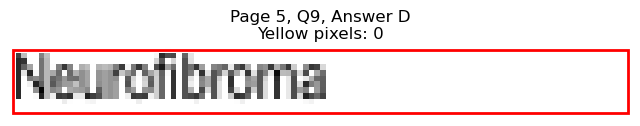


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=68.3, y0=646.5, x1=151.1, y1=657.6
Page 5, Q10, A: Yellow pixels: 134
Page 5, Q10, A: Total non-white pixels: 566
Page 5, Q10, A: Yellow percentage: 23.7%


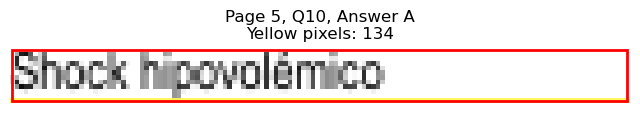

Page 5, Q10 - B: Detected box: x0=68.3, y0=659.1, x1=223.8, y1=670.2
Page 5, Q10, B: Yellow pixels: 1668
Page 5, Q10, B: Total non-white pixels: 2267
Page 5, Q10, B: Yellow percentage: 73.6%


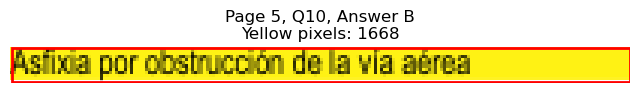

Page 5, Q10 - C: Detected box: x0=327.5, y0=646.5, x1=397.2, y1=657.6
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 350
Page 5, Q10, C: Yellow percentage: 0.0%


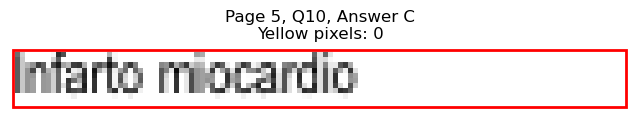

Page 5, Q10 - D: Detected box: x0=327.5, y0=659.1, x1=397.7, y1=670.2
Page 5, Q10, D: Yellow pixels: 0
Page 5, Q10, D: Total non-white pixels: 335
Page 5, Q10, D: Yellow percentage: 0.0%


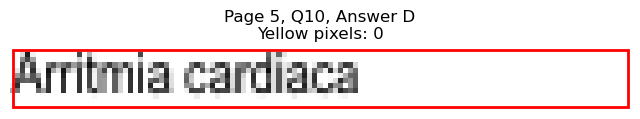


Page 5, Q10 - Selected Answer: B (based on yellow pixel count)




Page 5, Q11 - A: Detected box: x0=68.3, y0=697.0, x1=140.0, y1=708.1
Page 5, Q11, A: Yellow pixels: 0
Page 5, Q11, A: Total non-white pixels: 337
Page 5, Q11, A: Yellow percentage: 0.0%


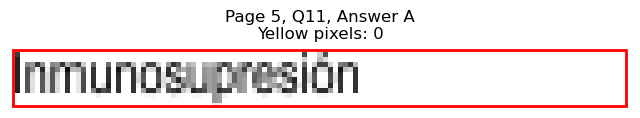

Page 5, Q11 - B: Detected box: x0=68.3, y0=709.6, x1=191.6, y1=720.7
Page 5, Q11, B: Yellow pixels: 0
Page 5, Q11, B: Total non-white pixels: 643
Page 5, Q11, B: Yellow percentage: 0.0%


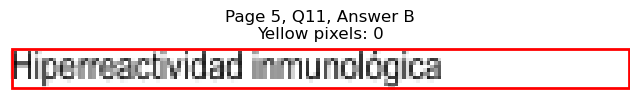

Page 5, Q11 - C: Detected box: x0=327.5, y0=697.0, x1=425.3, y1=708.1
Page 5, Q11, C: Yellow pixels: 149
Page 5, Q11, C: Total non-white pixels: 814
Page 5, Q11, C: Yellow percentage: 18.3%


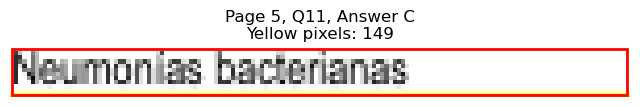

Page 5, Q11 - D: Detected box: x0=327.5, y0=709.6, x1=478.4, y1=720.7
Page 5, Q11, D: Yellow pixels: 1841
Page 5, Q11, D: Total non-white pixels: 2424
Page 5, Q11, D: Yellow percentage: 75.9%


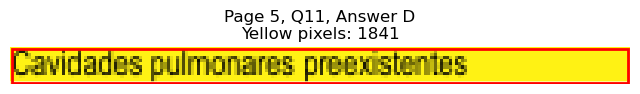


Page 5, Q11 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=154.1, y1=127.4
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 461
Page 6, Q1, A: Yellow percentage: 0.0%


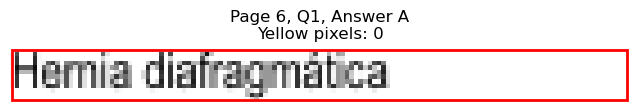

Page 6, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=142.0, y1=140.0
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 399
Page 6, Q1, B: Yellow percentage: 0.0%


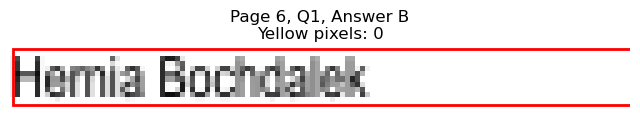

Page 6, Q1 - C: Detected box: x0=327.5, y0=116.4, x1=415.8, y1=127.4
Page 6, Q1, C: Yellow pixels: 139
Page 6, Q1, C: Total non-white pixels: 609
Page 6, Q1, C: Yellow percentage: 22.8%


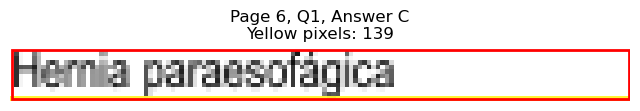

Page 6, Q1 - D: Detected box: x0=327.5, y0=129.0, x1=421.2, y1=140.0
Page 6, Q1, D: Yellow pixels: 1366
Page 6, Q1, D: Total non-white pixels: 1740
Page 6, Q1, D: Yellow percentage: 78.5%


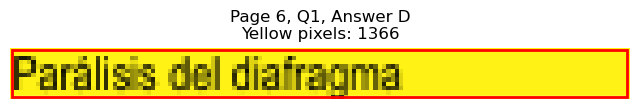


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=190.7, y1=190.5
Page 6, Q2, A: Yellow pixels: 1433
Page 6, Q2, A: Total non-white pixels: 2076
Page 6, Q2, A: Yellow percentage: 69.0%


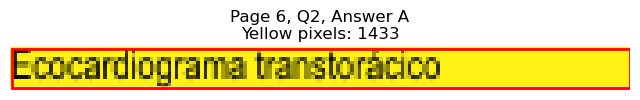

Page 6, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=185.6, y1=203.1
Page 6, Q2, B: Yellow pixels: 0
Page 6, Q2, B: Total non-white pixels: 526
Page 6, Q2, B: Yellow percentage: 0.0%


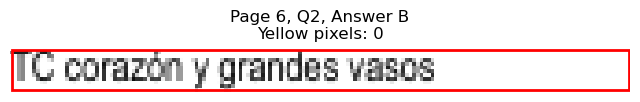

Page 6, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=380.6, y1=190.5
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 270
Page 6, Q2, C: Yellow percentage: 0.0%


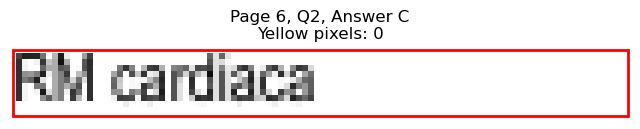

Page 6, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=415.8, y1=203.1
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 445
Page 6, Q2, D: Yellow percentage: 0.0%


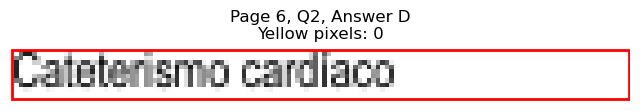


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=68.3, y0=242.6, x1=115.9, y1=253.6
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 235
Page 6, Q3, A: Yellow percentage: 0.0%


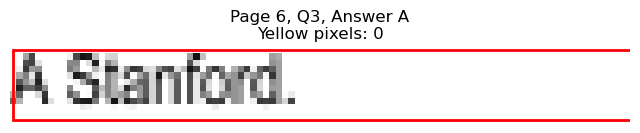

Page 6, Q3 - B: Detected box: x0=68.3, y0=255.2, x1=113.9, y1=266.2
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 219
Page 6, Q3, B: Yellow percentage: 0.0%


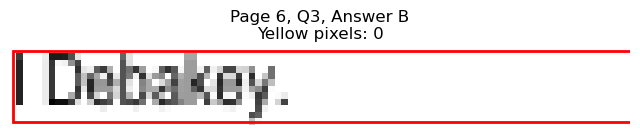

Page 6, Q3 - C: Detected box: x0=327.5, y0=242.6, x1=375.1, y1=253.6
Page 6, Q3, C: Yellow pixels: 915
Page 6, Q3, C: Total non-white pixels: 1188
Page 6, Q3, C: Yellow percentage: 77.0%


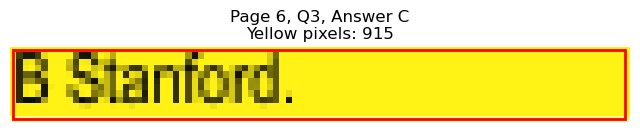

Page 6, Q3 - D: Detected box: x0=327.5, y0=255.2, x1=375.6, y1=266.2
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 238
Page 6, Q3, D: Yellow percentage: 0.0%


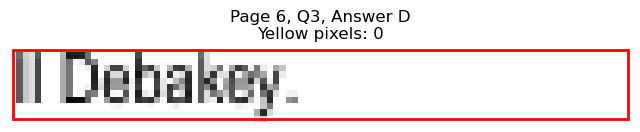


Page 6, Q3 - Selected Answer: C (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=68.3, y0=330.9, x1=137.0, y1=342.0
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 474
Page 6, Q4, A: Yellow percentage: 0.0%


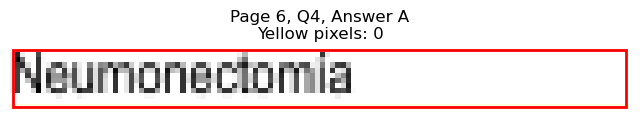

Page 6, Q4 - B: Detected box: x0=68.3, y0=343.6, x1=139.0, y1=354.7
Page 6, Q4, B: Yellow pixels: 1159
Page 6, Q4, B: Total non-white pixels: 1452
Page 6, Q4, B: Yellow percentage: 79.8%


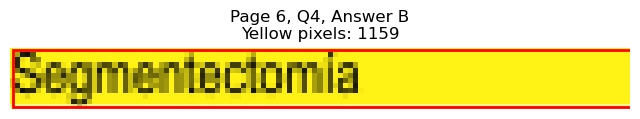

Page 6, Q4 - C: Detected box: x0=327.5, y0=330.9, x1=406.7, y1=342.0
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 390
Page 6, Q4, C: Yellow percentage: 0.0%


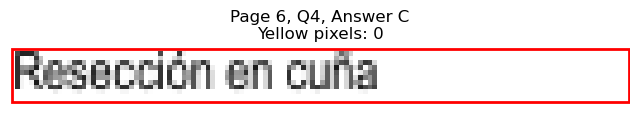

Page 6, Q4 - D: Detected box: x0=327.5, y0=343.6, x1=377.2, y1=354.7
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 222
Page 6, Q4, D: Yellow percentage: 0.0%


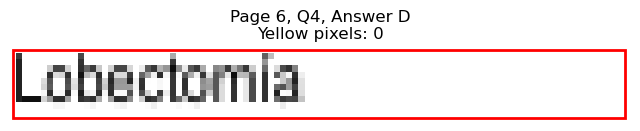


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=68.3, y0=406.6, x1=131.5, y1=417.7
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 326
Page 6, Q5, A: Yellow percentage: 0.0%


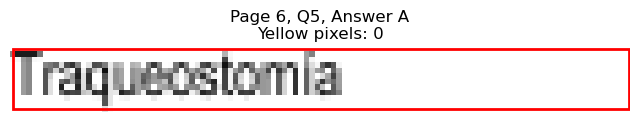

Page 6, Q5 - B: Detected box: x0=68.3, y0=419.4, x1=126.0, y1=430.4
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 305
Page 6, Q5, B: Yellow percentage: 0.0%


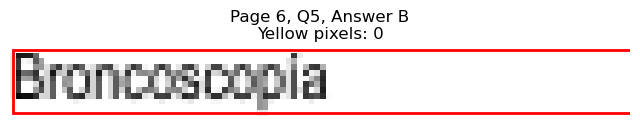

Page 6, Q5 - C: Detected box: x0=327.5, y0=406.6, x1=398.2, y1=417.7
Page 6, Q5, C: Yellow pixels: 1184
Page 6, Q5, C: Total non-white pixels: 1464
Page 6, Q5, C: Yellow percentage: 80.9%


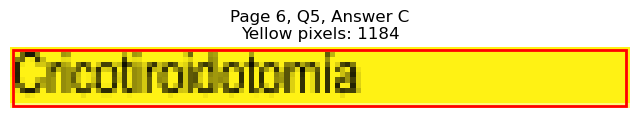

Page 6, Q5 - D: Detected box: x0=327.5, y0=419.4, x1=426.8, y1=430.4
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 512
Page 6, Q5, D: Yellow percentage: 0.0%


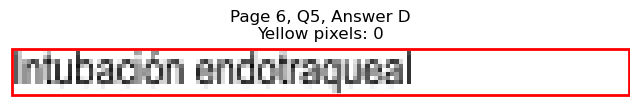


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=68.3, y0=457.2, x1=141.5, y1=468.2
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 351
Page 6, Q6, A: Yellow percentage: 0.0%


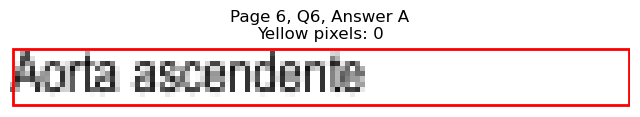

Page 6, Q6 - B: Detected box: x0=68.3, y0=469.8, x1=131.6, y1=480.8
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 318
Page 6, Q6, B: Yellow percentage: 0.0%


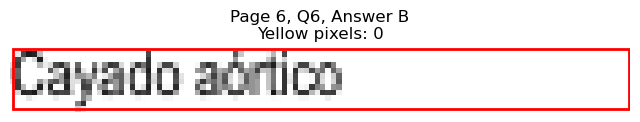

Page 6, Q6 - C: Detected box: x0=327.5, y0=457.2, x1=515.5, y1=468.2
Page 6, Q6, C: Yellow pixels: 213
Page 6, Q6, C: Total non-white pixels: 1370
Page 6, Q6, C: Yellow percentage: 15.5%


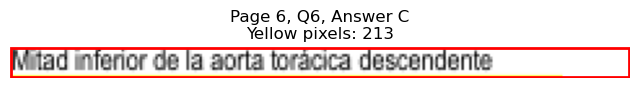

Page 6, Q6 - D: Detected box: x0=327.5, y0=469.8, x1=381.6, y1=480.8
Page 6, Q6, D: Yellow pixels: 1062
Page 6, Q6, D: Total non-white pixels: 1260
Page 6, Q6, D: Yellow percentage: 84.3%


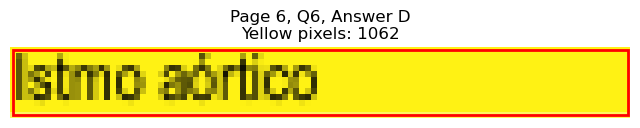


Page 6, Q6 - Selected Answer: D (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=68.3, y0=507.7, x1=298.9, y1=518.7
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 1174
Page 6, Q7, A: Yellow percentage: 0.0%


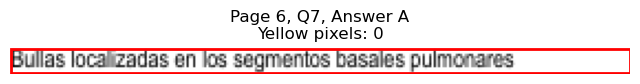

Page 6, Q7 - B: Detected box: x0=68.3, y0=520.3, x1=133.4, y1=531.3
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 348
Page 6, Q7, B: Yellow percentage: 0.0%


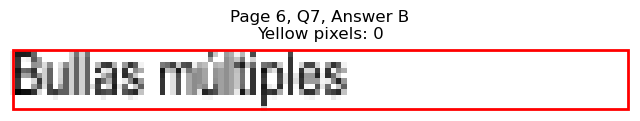

Page 6, Q7 - C: Detected box: x0=68.8, y0=532.9, x1=238.8, y1=543.9
Page 6, Q7, C: Yellow pixels: 1
Page 6, Q7, C: Total non-white pixels: 1074
Page 6, Q7, C: Yellow percentage: 0.1%


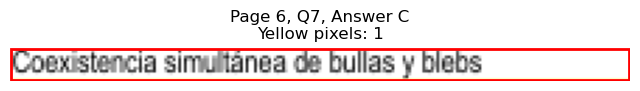

Page 6, Q7 - D: Detected box: x0=68.8, y0=545.5, x1=319.9, y1=556.5
Page 6, Q7, D: Yellow pixels: 2298
Page 6, Q7, D: Total non-white pixels: 3624
Page 6, Q7, D: Yellow percentage: 63.4%


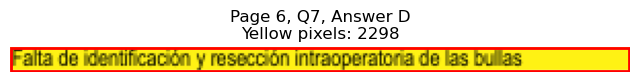


Page 6, Q7 - Selected Answer: D (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=68.3, y0=596.0, x1=193.2, y1=607.0
Page 6, Q8, A: Yellow pixels: 1622
Page 6, Q8, A: Total non-white pixels: 2112
Page 6, Q8, A: Yellow percentage: 76.8%


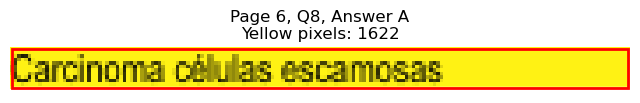

Page 6, Q8 - B: Detected box: x0=68.3, y0=608.6, x1=138.5, y1=619.6
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 349
Page 6, Q8, B: Yellow percentage: 0.0%


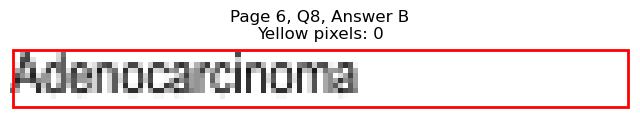

Page 6, Q8 - C: Detected box: x0=327.5, y0=596.0, x1=392.6, y1=607.0
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 350
Page 6, Q8, C: Yellow percentage: 0.0%


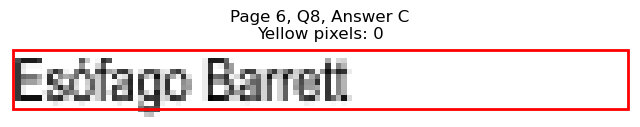

Page 6, Q8 - D: Detected box: x0=327.5, y0=608.6, x1=374.2, y1=619.6
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 221
Page 6, Q8, D: Yellow percentage: 0.0%


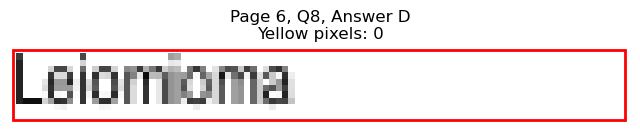


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=68.3, y0=646.5, x1=160.6, y1=657.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 471
Page 6, Q9, A: Yellow percentage: 0.0%


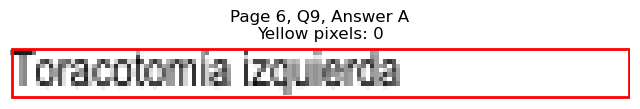

Page 6, Q9 - B: Detected box: x0=68.3, y0=659.1, x1=151.6, y1=670.2
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 427
Page 6, Q9, B: Yellow percentage: 0.0%


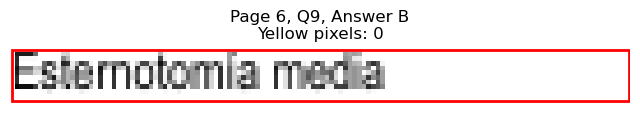

Page 6, Q9 - C: Detected box: x0=327.5, y0=646.5, x1=415.8, y1=657.6
Page 6, Q9, C: Yellow pixels: 1196
Page 6, Q9, C: Total non-white pixels: 1668
Page 6, Q9, C: Yellow percentage: 71.7%


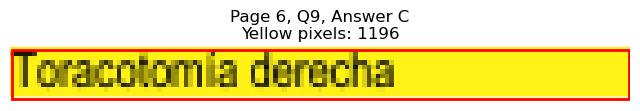

Page 6, Q9 - D: Detected box: x0=327.5, y0=659.1, x1=385.7, y1=670.2
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 308
Page 6, Q9, D: Yellow percentage: 0.0%


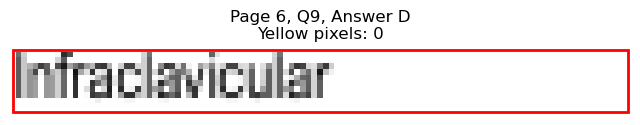


Page 6, Q9 - Selected Answer: C (based on yellow pixel count)




Page 6, Q10 - A: Detected box: x0=68.3, y0=709.6, x1=247.8, y1=720.7
Page 6, Q10, A: Yellow pixels: 1892
Page 6, Q10, A: Total non-white pixels: 2568
Page 6, Q10, A: Yellow percentage: 73.7%


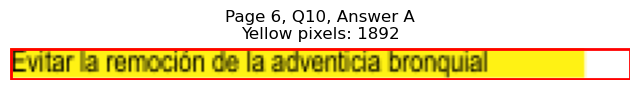

Page 6, Q10 - B: Detected box: x0=68.3, y0=722.2, x1=233.4, y1=733.3
Page 6, Q10, B: Yellow pixels: 0
Page 6, Q10, B: Total non-white pixels: 818
Page 6, Q10, B: Yellow percentage: 0.0%


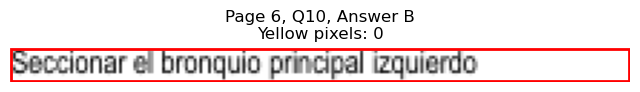

Page 6, Q10 - C: Detected box: x0=327.5, y0=709.6, x1=541.1, y1=720.7
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 1061
Page 6, Q10, C: Yellow percentage: 0.0%


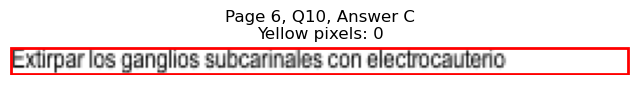

Page 6, Q10 - D: Detected box: x0=327.5, y0=722.2, x1=486.8, y1=733.3
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 803
Page 6, Q10, D: Yellow percentage: 0.0%


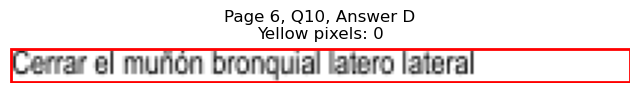


Page 6, Q10 - Selected Answer: A (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=117.5, y1=102.2
Page 7, Q1, A: Yellow pixels: 100
Page 7, Q1, A: Total non-white pixels: 459
Page 7, Q1, A: Yellow percentage: 21.8%


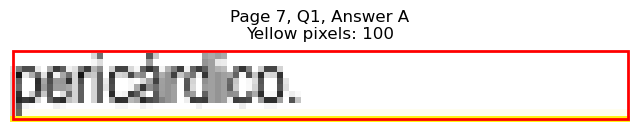

Page 7, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=127.4, y1=114.8
Page 7, Q1, B: Yellow pixels: 1093
Page 7, Q1, B: Total non-white pixels: 1320
Page 7, Q1, B: Yellow percentage: 82.8%


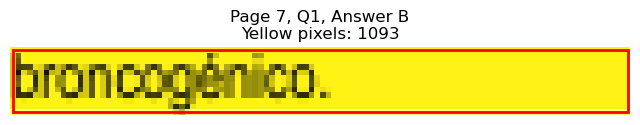

Page 7, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=371.2, y1=102.2
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 223
Page 7, Q1, C: Yellow percentage: 0.0%


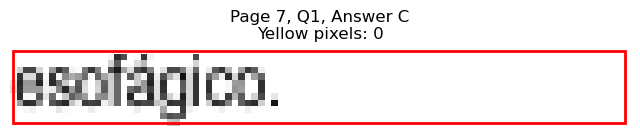

Page 7, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=387.7, y1=114.8
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 288
Page 7, Q1, D: Yellow percentage: 0.0%


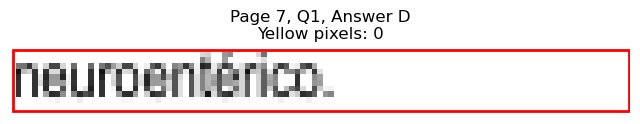


Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=68.3, y0=141.7, x1=167.6, y1=152.7
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 512
Page 7, Q2, A: Yellow percentage: 0.0%


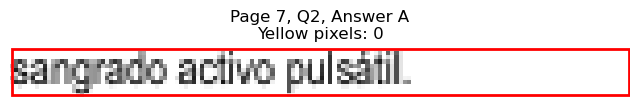

Page 7, Q2 - B: Detected box: x0=68.3, y0=154.3, x1=223.3, y1=165.3
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 746
Page 7, Q2, B: Yellow percentage: 0.0%


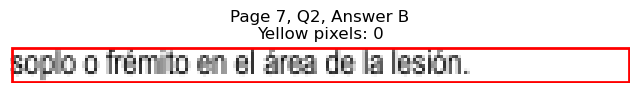

Page 7, Q2 - C: Detected box: x0=327.5, y0=141.7, x1=471.5, y1=152.7
Page 7, Q2, C: Yellow pixels: 1826
Page 7, Q2, C: Total non-white pixels: 2340
Page 7, Q2, C: Yellow percentage: 78.0%


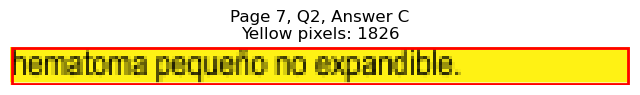

Page 7, Q2 - D: Detected box: x0=327.5, y0=154.3, x1=412.2, y1=165.3
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 406
Page 7, Q2, D: Yellow percentage: 0.0%


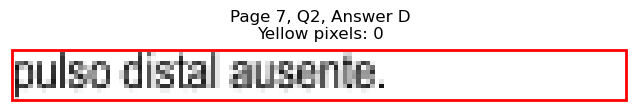


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=68.3, y0=204.7, x1=136.4, y1=215.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 355
Page 7, Q3, A: Yellow percentage: 0.0%


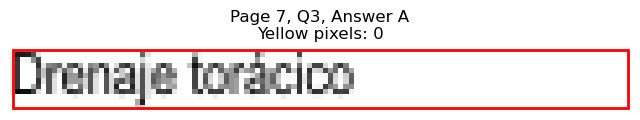

Page 7, Q3 - B: Detected box: x0=68.3, y0=217.4, x1=260.3, y1=228.4
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 991
Page 7, Q3, B: Yellow percentage: 0.0%


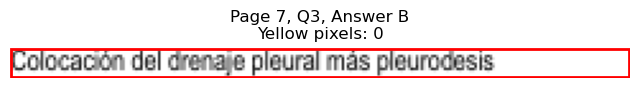

Page 7, Q3 - C: Detected box: x0=327.5, y0=204.7, x1=434.3, y1=215.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 731
Page 7, Q3, C: Yellow percentage: 0.0%


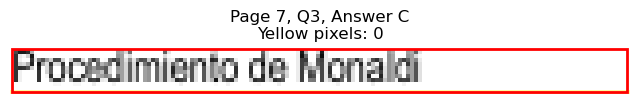

Page 7, Q3 - D: Detected box: x0=327.5, y0=217.4, x1=466.9, y1=228.4
Page 7, Q3, D: Yellow pixels: 1555
Page 7, Q3, D: Total non-white pixels: 2280
Page 7, Q3, D: Yellow percentage: 68.2%


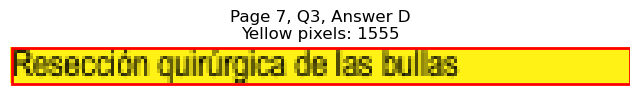


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=68.3, y0=255.2, x1=94.1, y1=266.2
Page 7, Q4, A: Yellow pixels: 762
Page 7, Q4, A: Total non-white pixels: 847
Page 7, Q4, A: Yellow percentage: 90.0%


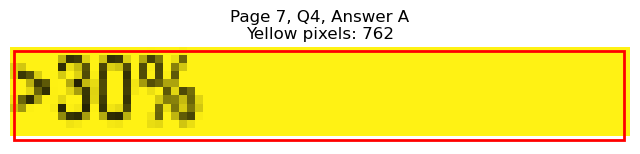

Page 7, Q4 - B: Detected box: x0=68.3, y0=267.8, x1=94.1, y1=278.8
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 122
Page 7, Q4, B: Yellow percentage: 0.0%


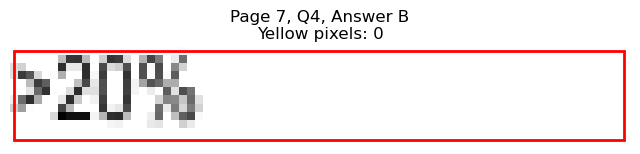

Page 7, Q4 - C: Detected box: x0=327.5, y0=255.2, x1=353.3, y1=266.2
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 115
Page 7, Q4, C: Yellow percentage: 0.0%


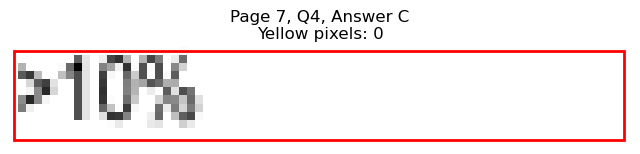

Page 7, Q4 - D: Detected box: x0=327.5, y0=267.8, x1=348.4, y1=278.8
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 97
Page 7, Q4, D: Yellow percentage: 0.0%


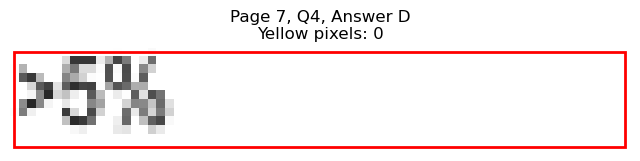


Page 7, Q4 - Selected Answer: A (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=68.3, y0=305.7, x1=102.8, y1=316.8
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 156
Page 7, Q5, A: Yellow percentage: 0.0%


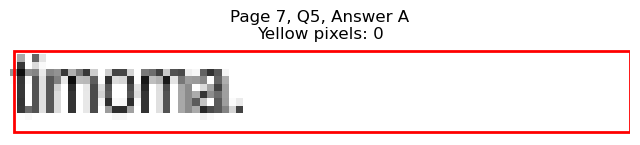

Page 7, Q5 - B: Detected box: x0=68.3, y0=318.3, x1=144.0, y1=329.4
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 388
Page 7, Q5, B: Yellow percentage: 0.0%


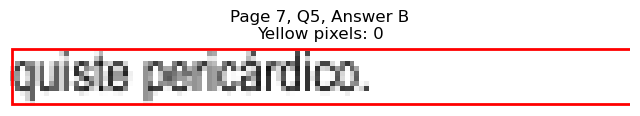

Page 7, Q5 - C: Detected box: x0=327.5, y0=305.7, x1=382.2, y1=316.8
Page 7, Q5, C: Yellow pixels: 1092
Page 7, Q5, C: Total non-white pixels: 1272
Page 7, Q5, C: Yellow percentage: 85.8%


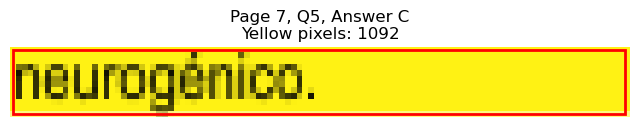

Page 7, Q5 - D: Detected box: x0=327.5, y0=318.3, x1=361.6, y1=329.4
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 145
Page 7, Q5, D: Yellow percentage: 0.0%


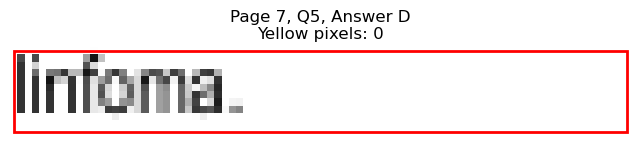


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=68.3, y0=368.8, x1=81.8, y1=379.9
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 56
Page 7, Q6, A: Yellow percentage: 0.0%


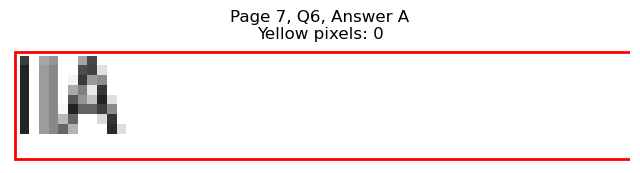

Page 7, Q6 - B: Detected box: x0=68.3, y0=381.4, x1=84.4, y1=392.5
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 64
Page 7, Q6, B: Yellow percentage: 0.0%


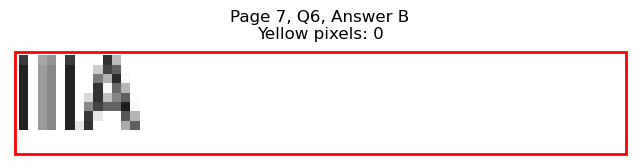

Page 7, Q6 - C: Detected box: x0=327.5, y0=368.8, x1=341.0, y1=379.9
Page 7, Q6, C: Yellow pixels: 727
Page 7, Q6, C: Total non-white pixels: 780
Page 7, Q6, C: Yellow percentage: 93.2%


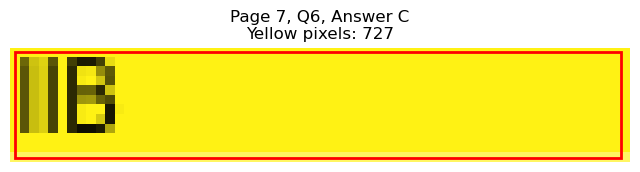

Page 7, Q6 - D: Detected box: x0=327.5, y0=381.4, x1=343.6, y1=392.5
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 88
Page 7, Q6, D: Yellow percentage: 0.0%


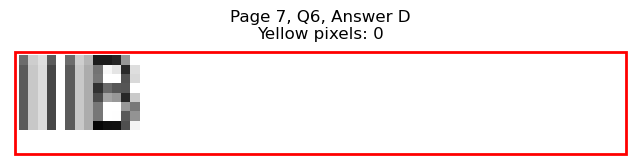


Page 7, Q6 - Selected Answer: C (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=68.3, y0=419.4, x1=315.0, y1=430.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 1231
Page 7, Q7, A: Yellow percentage: 0.0%


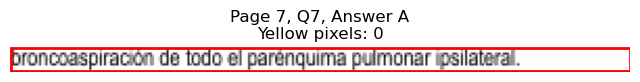

Page 7, Q7 - B: Detected box: x0=68.3, y0=432.0, x1=247.9, y1=443.0
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 1168
Page 7, Q7, B: Yellow percentage: 0.0%


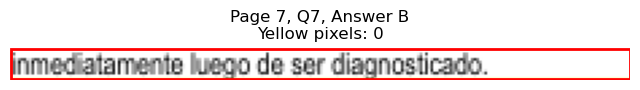

Page 7, Q7 - C: Detected box: x0=68.8, y0=444.6, x1=192.1, y1=455.6
Page 7, Q7, C: Yellow pixels: 1439
Page 7, Q7, C: Total non-white pixels: 2100
Page 7, Q7, C: Yellow percentage: 68.5%


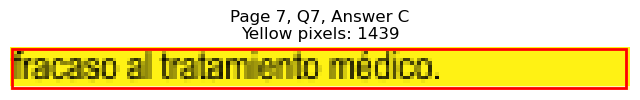

Page 7, Q7 - D: Detected box: x0=68.8, y0=457.2, x1=293.9, y1=468.2
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 1141
Page 7, Q7, D: Yellow percentage: 0.0%


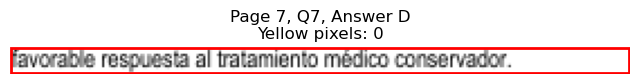


Page 7, Q7 - Selected Answer: C (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=68.3, y0=495.1, x1=206.6, y1=506.1
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 661
Page 7, Q8, A: Yellow percentage: 0.0%


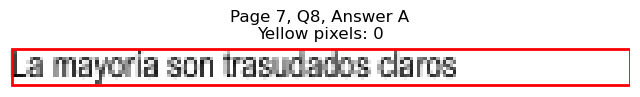

Page 7, Q8 - B: Detected box: x0=68.3, y0=507.7, x1=303.0, y1=518.7
Page 7, Q8, B: Yellow pixels: 285
Page 7, Q8, B: Total non-white pixels: 1427
Page 7, Q8, B: Yellow percentage: 20.0%


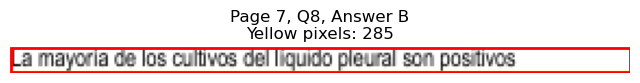

Page 7, Q8 - C: Detected box: x0=68.8, y0=520.3, x1=327.1, y1=531.3
Page 7, Q8, C: Yellow pixels: 2449
Page 7, Q8, C: Total non-white pixels: 3720
Page 7, Q8, C: Yellow percentage: 65.8%


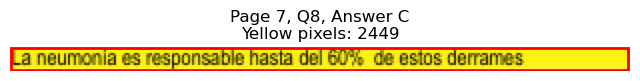

Page 7, Q8 - D: Detected box: x0=68.8, y0=532.9, x1=324.5, y1=543.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 1268
Page 7, Q8, D: Yellow percentage: 0.0%


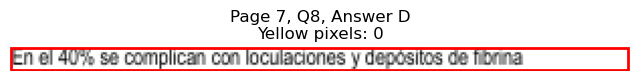


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=68.3, y0=596.0, x1=140.0, y1=607.0
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 347
Page 7, Q9, A: Yellow percentage: 0.0%


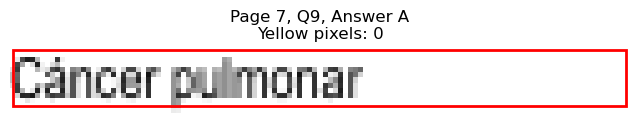

Page 7, Q9 - B: Detected box: x0=68.3, y0=608.6, x1=113.9, y1=619.6
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 220
Page 7, Q9, B: Yellow percentage: 0.0%


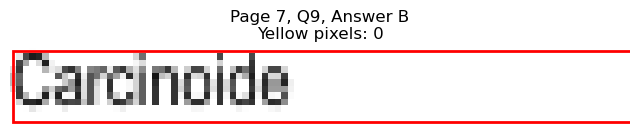

Page 7, Q9 - C: Detected box: x0=327.5, y0=596.0, x1=466.0, y1=607.0
Page 7, Q9, C: Yellow pixels: 1764
Page 7, Q9, C: Total non-white pixels: 2268
Page 7, Q9, C: Yellow percentage: 77.8%


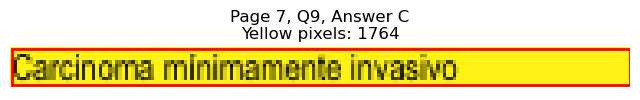

Page 7, Q9 - D: Detected box: x0=327.5, y0=608.6, x1=374.6, y1=619.6
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 218
Page 7, Q9, D: Yellow percentage: 0.0%


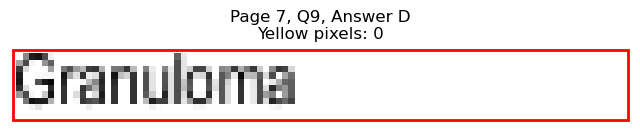


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=137.0, y1=695.4
Page 7, Q10, A: Yellow pixels: 0
Page 7, Q10, A: Total non-white pixels: 354
Page 7, Q10, A: Yellow percentage: 0.0%


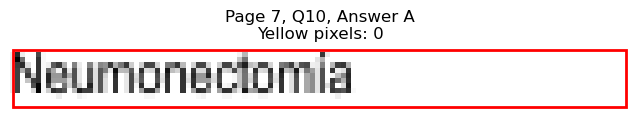

Page 7, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=188.2, y1=708.1
Page 7, Q10, B: Yellow pixels: 0
Page 7, Q10, B: Total non-white pixels: 598
Page 7, Q10, B: Yellow percentage: 0.0%


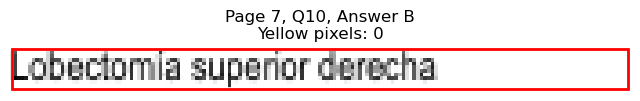

Page 7, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=535.6, y1=695.4
Page 7, Q10, C: Yellow pixels: 1554
Page 7, Q10, C: Total non-white pixels: 2556
Page 7, Q10, C: Yellow percentage: 60.8%


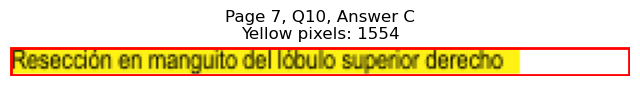

Page 7, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=486.5, y1=708.1
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 800
Page 7, Q10, D: Yellow percentage: 0.0%


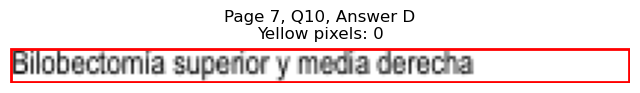


Page 7, Q10 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 11 questions
Page 8, Q1 - A: Detected box: x0=68.3, y0=129.0, x1=169.1, y1=140.0
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 478
Page 8, Q1, A: Yellow percentage: 0.0%


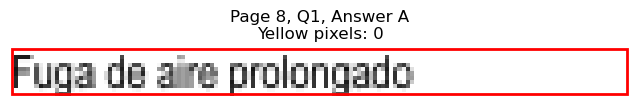

Page 8, Q1 - B: Detected box: x0=68.3, y0=141.7, x1=145.6, y1=152.7
Page 8, Q1, B: Yellow pixels: 0
Page 8, Q1, B: Total non-white pixels: 373
Page 8, Q1, B: Yellow percentage: 0.0%


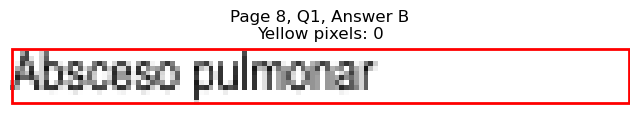

Page 8, Q1 - C: Detected box: x0=327.5, y0=129.0, x1=414.2, y1=140.0
Page 8, Q1, C: Yellow pixels: 1336
Page 8, Q1, C: Total non-white pixels: 1656
Page 8, Q1, C: Yellow percentage: 80.7%


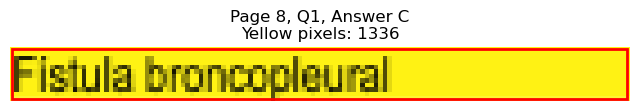

Page 8, Q1 - D: Detected box: x0=327.5, y0=141.7, x1=476.4, y1=152.7
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 772
Page 8, Q1, D: Yellow percentage: 0.0%


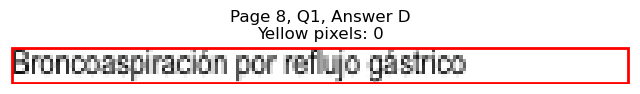


Page 8, Q1 - Selected Answer: C (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=68.3, y0=179.5, x1=126.5, y1=190.5
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 311
Page 8, Q2, A: Yellow percentage: 0.0%


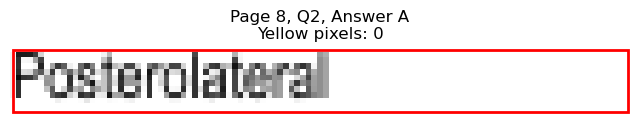

Page 8, Q2 - B: Detected box: x0=68.3, y0=192.1, x1=157.1, y1=203.1
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 449
Page 8, Q2, B: Yellow percentage: 0.0%


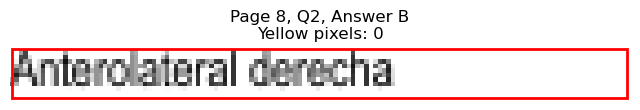

Page 8, Q2 - C: Detected box: x0=327.5, y0=179.5, x1=352.6, y1=190.5
Page 8, Q2, C: Yellow pixels: 76
Page 8, Q2, C: Total non-white pixels: 205
Page 8, Q2, C: Yellow percentage: 37.1%


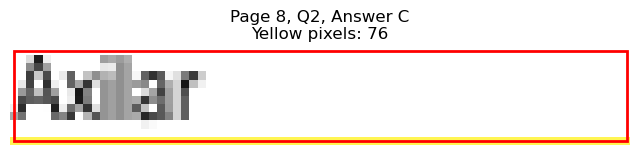

Page 8, Q2 - D: Detected box: x0=327.5, y0=192.1, x1=420.2, y1=203.1
Page 8, Q2, D: Yellow pixels: 1230
Page 8, Q2, D: Total non-white pixels: 1586
Page 8, Q2, D: Yellow percentage: 77.6%


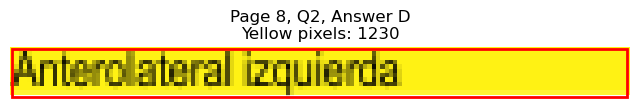


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=90.8, y1=241.0
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 91
Page 8, Q3, A: Yellow percentage: 0.0%


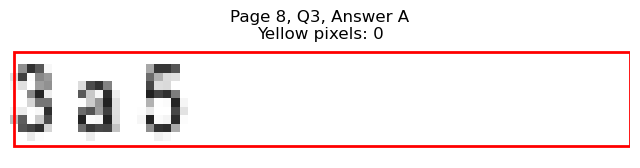

Page 8, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=90.8, y1=253.6
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 86
Page 8, Q3, B: Yellow percentage: 0.0%


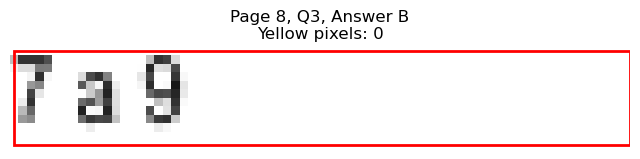

Page 8, Q3 - C: Detected box: x0=327.5, y0=230.0, x1=360.1, y1=241.0
Page 8, Q3, C: Yellow pixels: 907
Page 8, Q3, C: Total non-white pixels: 1008
Page 8, Q3, C: Yellow percentage: 90.0%


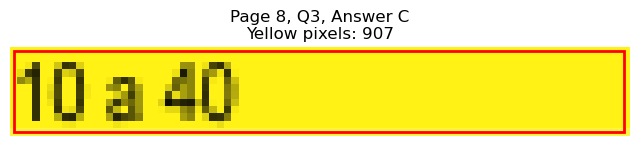

Page 8, Q3 - D: Detected box: x0=327.5, y0=242.6, x1=360.1, y1=253.6
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 160
Page 8, Q3, D: Yellow percentage: 0.0%


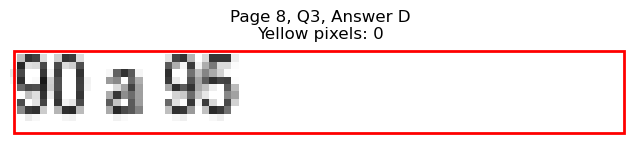


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=68.3, y0=293.1, x1=82.3, y1=304.2
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 67
Page 8, Q4, A: Yellow percentage: 0.0%


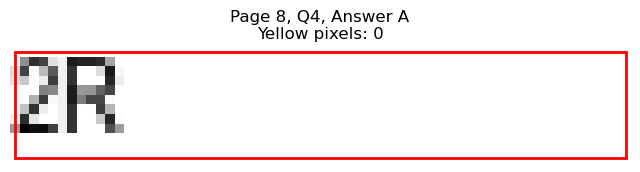

Page 8, Q4 - B: Detected box: x0=56.6, y0=305.7, x1=65.2, y1=316.8
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 74
Page 8, Q4, B: Yellow percentage: 0.0%


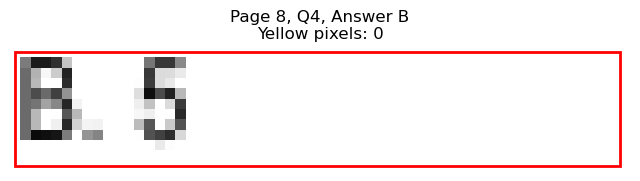

Page 8, Q4 - C: Detected box: x0=327.5, y0=293.1, x1=341.5, y1=304.2
Page 8, Q4, C: Yellow pixels: 663
Page 8, Q4, C: Total non-white pixels: 715
Page 8, Q4, C: Yellow percentage: 92.7%


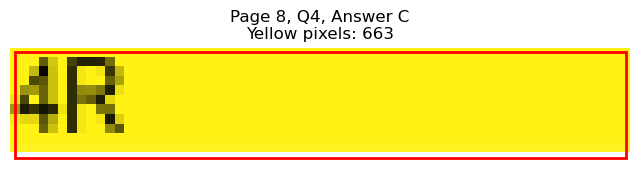

Page 8, Q4 - D: Detected box: x0=327.5, y0=305.7, x1=340.1, y1=316.8
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 57
Page 8, Q4, D: Yellow percentage: 0.0%


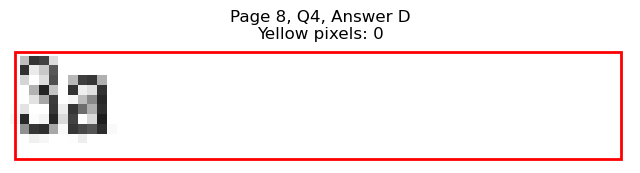


Page 8, Q4 - Selected Answer: C (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=68.3, y0=343.6, x1=121.9, y1=354.7
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 264
Page 8, Q5, A: Yellow percentage: 0.0%


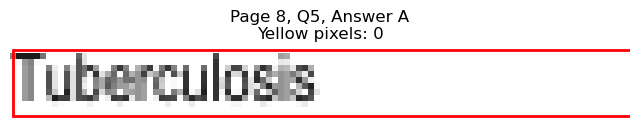

Page 8, Q5 - B: Detected box: x0=68.3, y0=356.2, x1=143.0, y1=367.3
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 388
Page 8, Q5, B: Yellow percentage: 0.0%


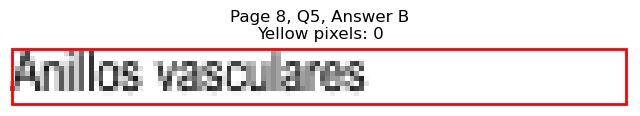

Page 8, Q5 - C: Detected box: x0=327.5, y0=343.6, x1=376.7, y1=354.7
Page 8, Q5, C: Yellow pixels: 1010
Page 8, Q5, C: Total non-white pixels: 1200
Page 8, Q5, C: Yellow percentage: 84.2%


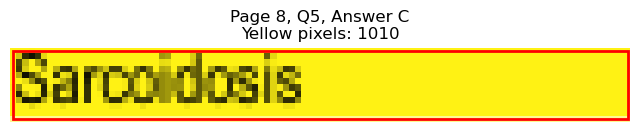

Page 8, Q5 - D: Detected box: x0=327.5, y0=356.2, x1=352.6, y1=367.3
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 128
Page 8, Q5, D: Yellow percentage: 0.0%


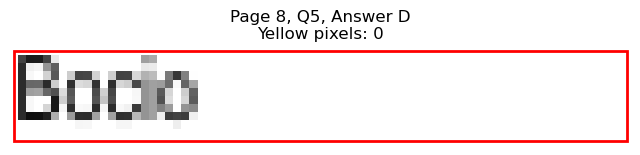


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=68.3, y0=394.0, x1=168.1, y1=405.1
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 514
Page 8, Q6, A: Yellow percentage: 0.0%


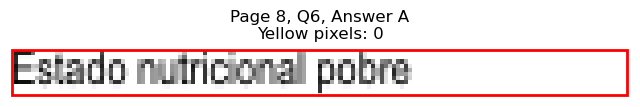

Page 8, Q6 - B: Detected box: x0=68.3, y0=406.6, x1=186.6, y1=417.7
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 617
Page 8, Q6, B: Yellow percentage: 0.0%


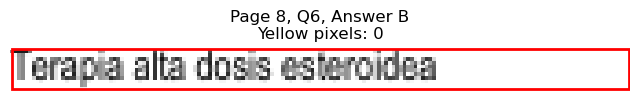

Page 8, Q6 - C: Detected box: x0=327.5, y0=394.0, x1=431.3, y1=405.1
Page 8, Q6, C: Yellow pixels: 155
Page 8, Q6, C: Total non-white pixels: 861
Page 8, Q6, C: Yellow percentage: 18.0%


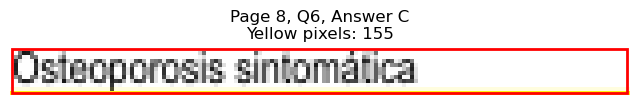

Page 8, Q6 - D: Detected box: x0=327.5, y0=406.6, x1=430.3, y1=417.7
Page 8, Q6, D: Yellow pixels: 1430
Page 8, Q6, D: Total non-white pixels: 1848
Page 8, Q6, D: Yellow percentage: 77.4%


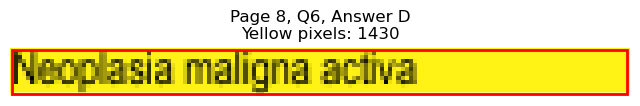


Page 8, Q6 - Selected Answer: D (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=68.3, y0=444.6, x1=90.8, y1=455.6
Page 8, Q7, A: Yellow pixels: 73
Page 8, Q7, A: Total non-white pixels: 155
Page 8, Q7, A: Yellow percentage: 47.1%


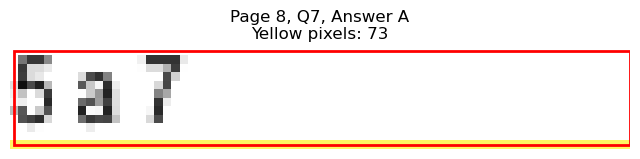

Page 8, Q7 - B: Detected box: x0=68.3, y0=457.2, x1=100.9, y1=468.2
Page 8, Q7, B: Yellow pixels: 806
Page 8, Q7, B: Total non-white pixels: 913
Page 8, Q7, B: Yellow percentage: 88.3%


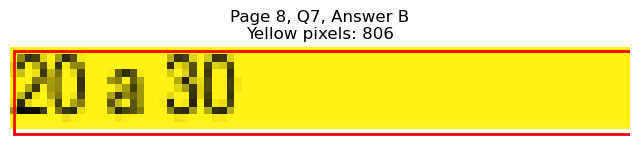

Page 8, Q7 - C: Detected box: x0=327.5, y0=444.6, x1=360.1, y1=455.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 127
Page 8, Q7, C: Yellow percentage: 0.0%


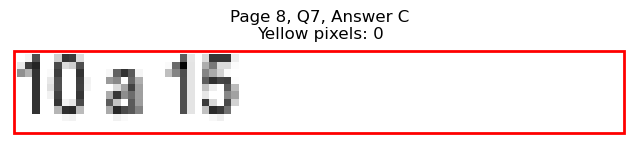

Page 8, Q7 - D: Detected box: x0=327.5, y0=457.2, x1=360.1, y1=468.2
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 153
Page 8, Q7, D: Yellow percentage: 0.0%


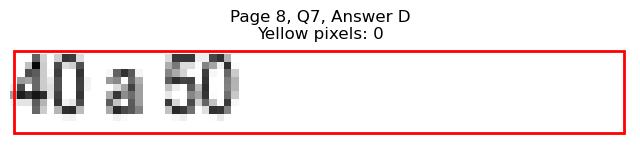


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=68.3, y0=520.3, x1=173.6, y1=531.3
Page 8, Q8, A: Yellow pixels: 1321
Page 8, Q8, A: Total non-white pixels: 1872
Page 8, Q8, A: Yellow percentage: 70.6%


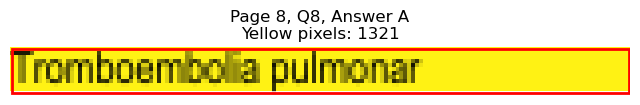

Page 8, Q8 - B: Detected box: x0=68.3, y0=532.9, x1=138.0, y1=543.9
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 330
Page 8, Q8, B: Yellow percentage: 0.0%


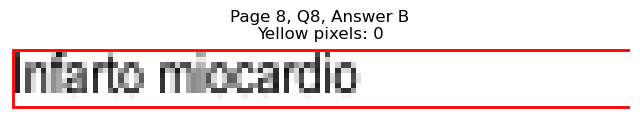

Page 8, Q8 - C: Detected box: x0=327.5, y0=520.3, x1=392.2, y1=531.3
Page 8, Q8, C: Yellow pixels: 0
Page 8, Q8, C: Total non-white pixels: 322
Page 8, Q8, C: Yellow percentage: 0.0%


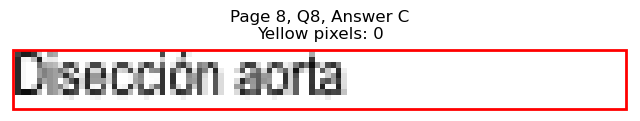

Page 8, Q8 - D: Detected box: x0=327.5, y0=532.9, x1=398.8, y1=543.9
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 360
Page 8, Q8, D: Yellow percentage: 0.0%


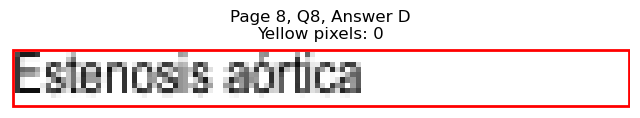


Page 8, Q8 - Selected Answer: A (based on yellow pixel count)




Page 8, Q9 - A: Detected box: x0=68.3, y0=608.6, x1=79.3, y1=619.6
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 46
Page 8, Q9, A: Yellow percentage: 0.0%


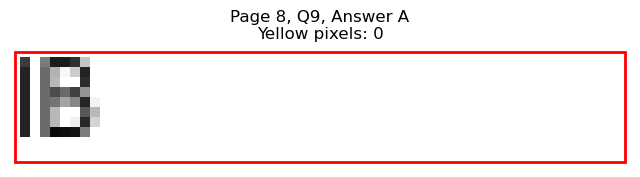

Page 8, Q9 - B: Detected box: x0=68.3, y0=621.3, x1=84.4, y1=632.4
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 70
Page 8, Q9, B: Yellow percentage: 0.0%


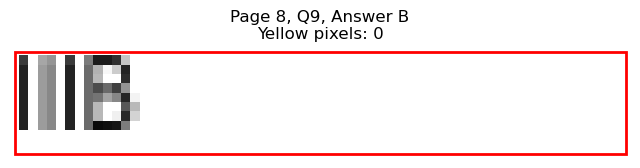

Page 8, Q9 - C: Detected box: x0=327.5, y0=608.6, x1=341.0, y1=619.6
Page 8, Q9, C: Yellow pixels: 65
Page 8, Q9, C: Total non-white pixels: 128
Page 8, Q9, C: Yellow percentage: 50.8%


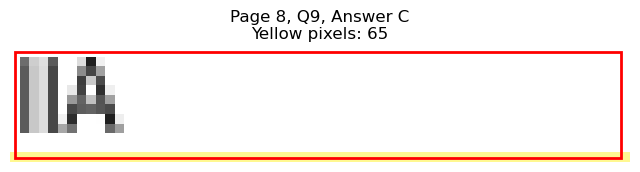

Page 8, Q9 - D: Detected box: x0=327.5, y0=621.3, x1=343.6, y1=632.4
Page 8, Q9, D: Yellow pixels: 669
Page 8, Q9, D: Total non-white pixels: 804
Page 8, Q9, D: Yellow percentage: 83.2%


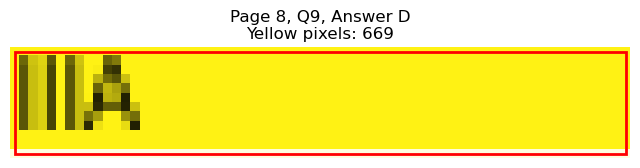


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)




Page 8, Q10 - A: Detected box: x0=68.3, y0=684.3, x1=182.6, y1=695.4
Page 8, Q10, A: Yellow pixels: 0
Page 8, Q10, A: Total non-white pixels: 580
Page 8, Q10, A: Yellow percentage: 0.0%


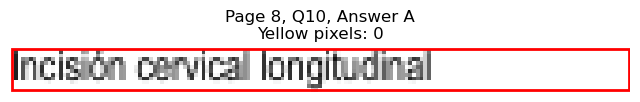

Page 8, Q10 - B: Detected box: x0=68.3, y0=697.0, x1=217.7, y1=708.1
Page 8, Q10, B: Yellow pixels: 0
Page 8, Q10, B: Total non-white pixels: 782
Page 8, Q10, B: Yellow percentage: 0.0%


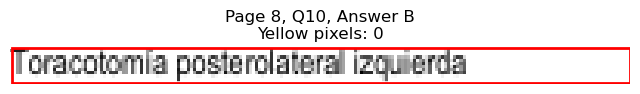

Page 8, Q10 - C: Detected box: x0=327.5, y0=684.3, x1=444.4, y1=695.4
Page 8, Q10, C: Yellow pixels: 168
Page 8, Q10, C: Total non-white pixels: 752
Page 8, Q10, C: Yellow percentage: 22.3%


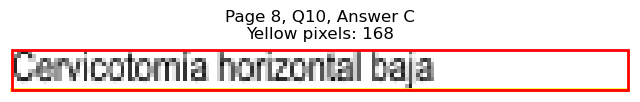

Page 8, Q10 - D: Detected box: x0=327.5, y0=697.0, x1=472.9, y1=708.1
Page 8, Q10, D: Yellow pixels: 1582
Page 8, Q10, D: Total non-white pixels: 2158
Page 8, Q10, D: Yellow percentage: 73.3%


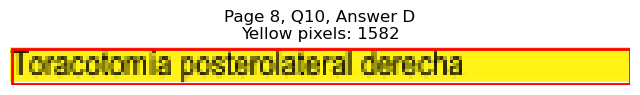


Page 8, Q10 - Selected Answer: D (based on yellow pixel count)




Page 8, Q11 - A: Detected box: x0=68.3, y0=734.8, x1=211.7, y1=745.9
Page 8, Q11, A: Yellow pixels: 1790
Page 8, Q11, A: Total non-white pixels: 2328
Page 8, Q11, A: Yellow percentage: 76.9%


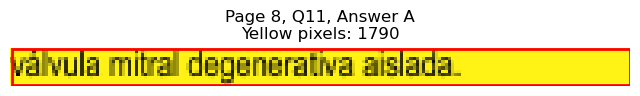

Page 8, Q11 - B: Detected box: x0=68.3, y0=747.4, x1=218.3, y1=758.5
Page 8, Q11, B: Yellow pixels: 0
Page 8, Q11, B: Total non-white pixels: 743
Page 8, Q11, B: Yellow percentage: 0.0%


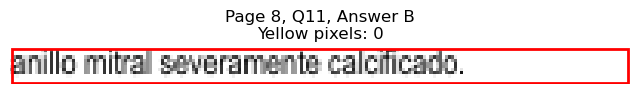

Page 8, Q11 - C: Detected box: x0=327.5, y0=734.8, x1=442.3, y1=745.9
Page 8, Q11, C: Yellow pixels: 0
Page 8, Q11, C: Total non-white pixels: 577
Page 8, Q11, C: Yellow percentage: 0.0%


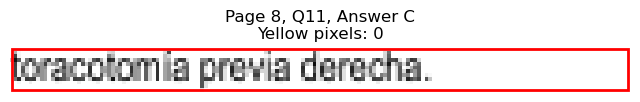

Page 8, Q11 - D: Detected box: x0=327.5, y0=747.4, x1=449.3, y1=758.5
Page 8, Q11, D: Yellow pixels: 0
Page 8, Q11, D: Total non-white pixels: 628
Page 8, Q11, D: Yellow percentage: 0.0%


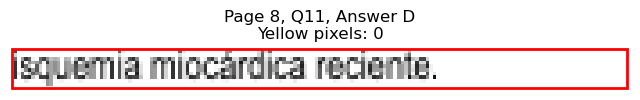


Page 8, Q11 - Selected Answer: A (based on yellow pixel count)





Page 9: Found 10 questions
Page 9, Q1 - A: Detected box: x0=68.3, y0=91.2, x1=100.9, y1=102.2
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 161
Page 9, Q1, A: Yellow percentage: 0.0%


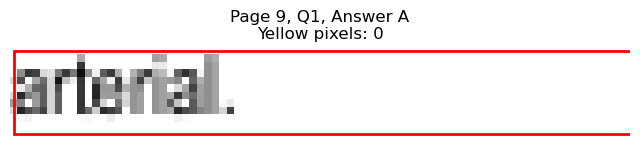

Page 9, Q1 - B: Detected box: x0=68.3, y0=103.8, x1=92.9, y1=114.8
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 118
Page 9, Q1, B: Yellow percentage: 0.0%


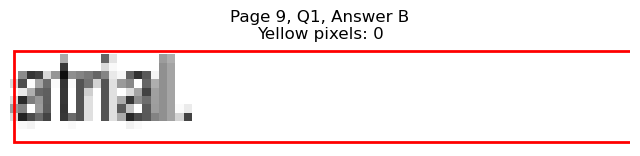

Page 9, Q1 - C: Detected box: x0=327.5, y0=91.2, x1=382.2, y1=102.2
Page 9, Q1, C: Yellow pixels: 106
Page 9, Q1, C: Total non-white pixels: 469
Page 9, Q1, C: Yellow percentage: 22.6%


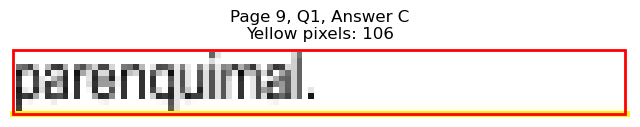

Page 9, Q1 - D: Detected box: x0=327.5, y0=103.8, x1=369.6, y1=114.8
Page 9, Q1, D: Yellow pixels: 985
Page 9, Q1, D: Total non-white pixels: 1116
Page 9, Q1, D: Yellow percentage: 88.3%


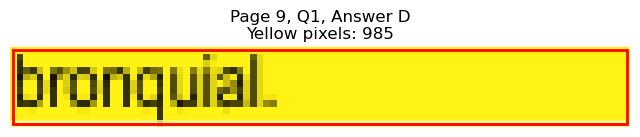


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=68.3, y0=154.3, x1=228.8, y1=165.3
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 806
Page 9, Q2, A: Yellow percentage: 0.0%


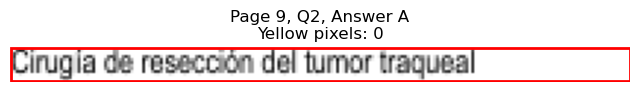

Page 9, Q2 - B: Detected box: x0=68.3, y0=166.9, x1=126.0, y1=177.9
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 425
Page 9, Q2, B: Yellow percentage: 0.0%


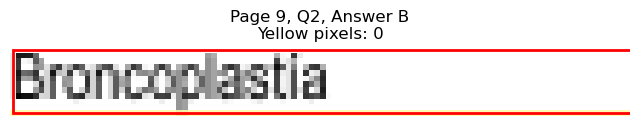

Page 9, Q2 - C: Detected box: x0=68.8, y0=179.5, x1=219.1, y1=190.5
Page 9, Q2, C: Yellow pixels: 1663
Page 9, Q2, C: Total non-white pixels: 2424
Page 9, Q2, C: Yellow percentage: 68.6%


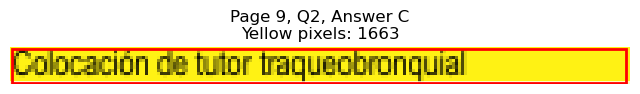

Page 9, Q2 - D: Detected box: x0=68.8, y0=192.1, x1=302.0, y1=203.1
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 1151
Page 9, Q2, D: Yellow percentage: 0.0%


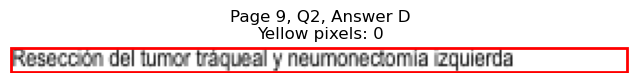


Page 9, Q2 - Selected Answer: C (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=68.3, y0=230.0, x1=228.8, y1=241.0
Page 9, Q3, A: Yellow pixels: 211
Page 9, Q3, A: Total non-white pixels: 1193
Page 9, Q3, A: Yellow percentage: 17.7%


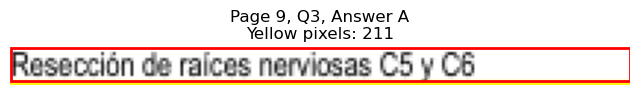

Page 9, Q3 - B: Detected box: x0=68.3, y0=242.6, x1=294.0, y1=253.6
Page 9, Q3, B: Yellow pixels: 2171
Page 9, Q3, B: Total non-white pixels: 3312
Page 9, Q3, B: Yellow percentage: 65.5%


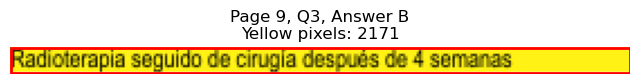

Page 9, Q3 - C: Detected box: x0=68.8, y0=255.2, x1=174.6, y1=266.2
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 522
Page 9, Q3, C: Yellow percentage: 0.0%


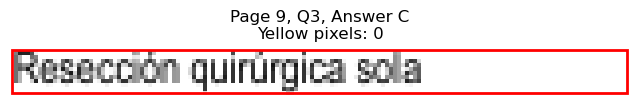

Page 9, Q3 - D: Detected box: x0=68.8, y0=267.8, x1=245.3, y1=278.8
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 839
Page 9, Q3, D: Yellow percentage: 0.0%


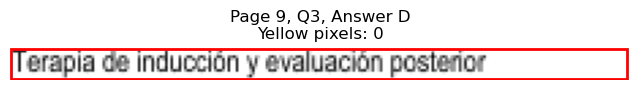


Page 9, Q3 - Selected Answer: B (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=68.3, y0=305.7, x1=152.0, y1=316.8
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 426
Page 9, Q4, A: Yellow percentage: 0.0%


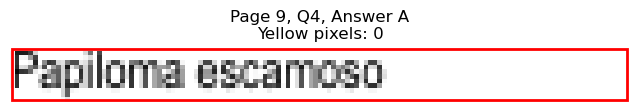

Page 9, Q4 - B: Detected box: x0=68.3, y0=318.3, x1=152.0, y1=329.4
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 419
Page 9, Q4, B: Yellow percentage: 0.0%


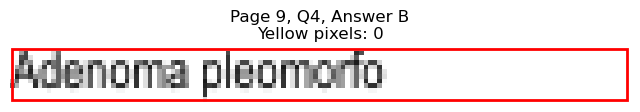

Page 9, Q4 - C: Detected box: x0=327.5, y0=305.7, x1=447.8, y1=316.8
Page 9, Q4, C: Yellow pixels: 171
Page 9, Q4, C: Total non-white pixels: 770
Page 9, Q4, C: Yellow percentage: 22.2%


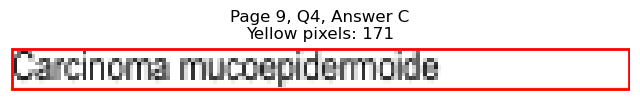

Page 9, Q4 - D: Detected box: x0=327.5, y0=318.3, x1=459.8, y1=329.4
Page 9, Q4, D: Yellow pixels: 1526
Page 9, Q4, D: Total non-white pixels: 2196
Page 9, Q4, D: Yellow percentage: 69.5%


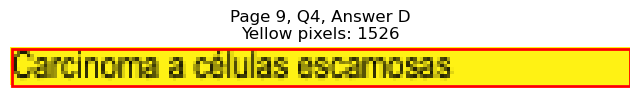


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=68.3, y0=356.2, x1=101.9, y1=367.3
Page 9, Q5, A: Yellow pixels: 805
Page 9, Q5, A: Total non-white pixels: 1008
Page 9, Q5, A: Yellow percentage: 79.9%


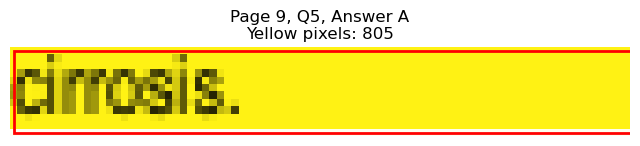

Page 9, Q5 - B: Detected box: x0=68.3, y0=368.8, x1=112.0, y1=379.9
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 214
Page 9, Q5, B: Yellow percentage: 0.0%


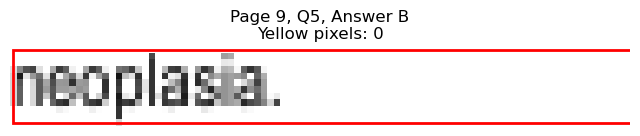

Page 9, Q5 - C: Detected box: x0=327.5, y0=356.2, x1=366.1, y1=367.3
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 181
Page 9, Q5, C: Yellow percentage: 0.0%


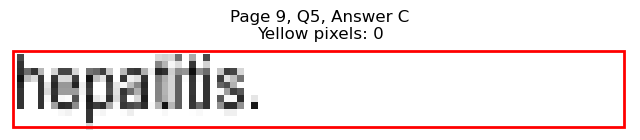

Page 9, Q5 - D: Detected box: x0=327.5, y0=368.8, x1=360.6, y1=379.9
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 154
Page 9, Q5, D: Yellow percentage: 0.0%


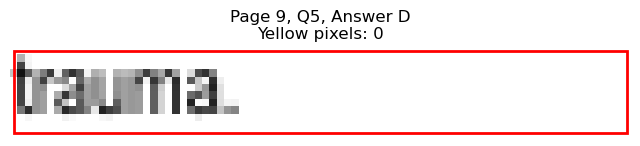


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=68.3, y0=444.6, x1=217.7, y1=455.6
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 768
Page 9, Q6, A: Yellow percentage: 0.0%


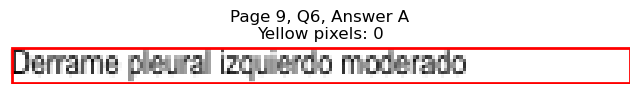

Page 9, Q6 - B: Detected box: x0=68.3, y0=457.2, x1=216.7, y1=468.2
Page 9, Q6, B: Yellow pixels: 199
Page 9, Q6, B: Total non-white pixels: 1150
Page 9, Q6, B: Yellow percentage: 17.3%


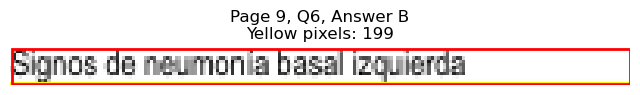

Page 9, Q6 - C: Detected box: x0=68.8, y0=469.8, x1=307.9, y1=480.8
Page 9, Q6, C: Yellow pixels: 2602
Page 9, Q6, C: Total non-white pixels: 3480
Page 9, Q6, C: Yellow percentage: 74.8%


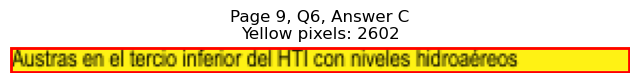

Page 9, Q6 - D: Detected box: x0=68.8, y0=482.5, x1=148.0, y1=493.5
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 407
Page 9, Q6, D: Yellow percentage: 0.0%


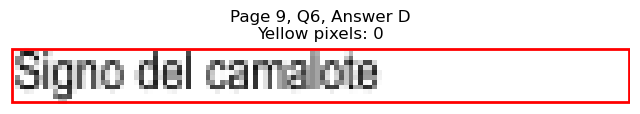


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=68.3, y0=520.3, x1=139.0, y1=531.3
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 352
Page 9, Q7, A: Yellow percentage: 0.0%


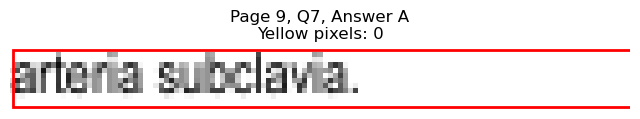

Page 9, Q7 - B: Detected box: x0=68.3, y0=532.9, x1=116.9, y1=543.9
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 230
Page 9, Q7, B: Yellow percentage: 0.0%


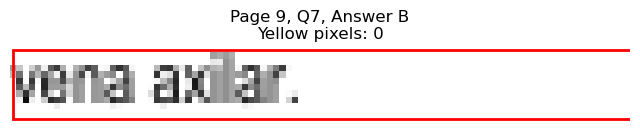

Page 9, Q7 - C: Detected box: x0=327.5, y0=520.3, x1=392.2, y1=531.3
Page 9, Q7, C: Yellow pixels: 1040
Page 9, Q7, C: Total non-white pixels: 1392
Page 9, Q7, C: Yellow percentage: 74.7%


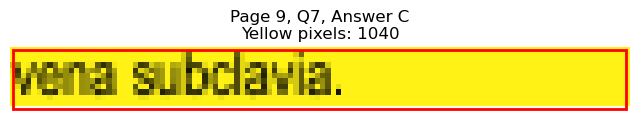

Page 9, Q7 - D: Detected box: x0=327.5, y0=532.9, x1=392.6, y1=543.9
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 335
Page 9, Q7, D: Yellow percentage: 0.0%


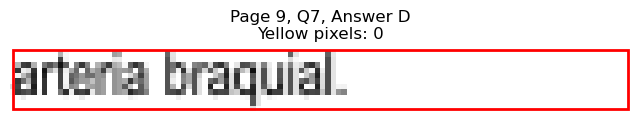


Page 9, Q7 - Selected Answer: C (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=68.3, y0=583.4, x1=151.1, y1=594.4
Page 9, Q8, A: Yellow pixels: 134
Page 9, Q8, A: Total non-white pixels: 540
Page 9, Q8, A: Yellow percentage: 24.8%


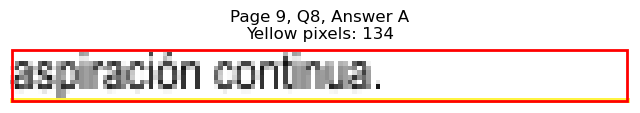

Page 9, Q8 - B: Detected box: x0=68.3, y0=596.0, x1=146.5, y1=607.0
Page 9, Q8, B: Yellow pixels: 1252
Page 9, Q8, B: Total non-white pixels: 1550
Page 9, Q8, B: Yellow percentage: 80.8%


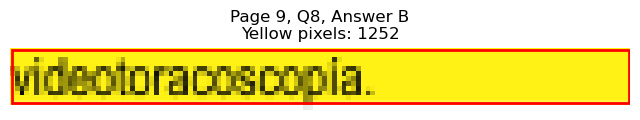

Page 9, Q8 - C: Detected box: x0=327.5, y0=583.4, x1=378.6, y1=594.4
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 248
Page 9, Q8, C: Yellow percentage: 0.0%


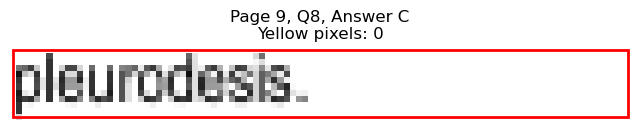

Page 9, Q8 - D: Detected box: x0=327.5, y0=596.0, x1=394.7, y1=607.0
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 319
Page 9, Q8, D: Yellow percentage: 0.0%


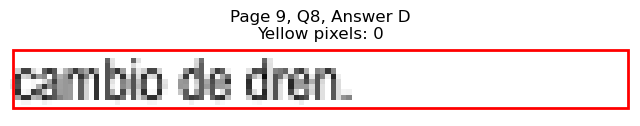


Page 9, Q8 - Selected Answer: B (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=68.3, y0=671.7, x1=151.7, y1=682.8
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 406
Page 9, Q9, A: Yellow percentage: 0.0%


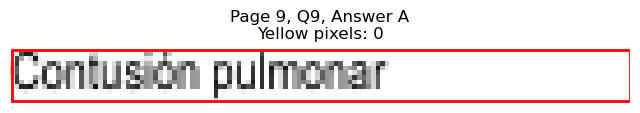

Page 9, Q9 - B: Detected box: x0=68.3, y0=684.3, x1=148.6, y1=695.4
Page 9, Q9, B: Yellow pixels: 0
Page 9, Q9, B: Total non-white pixels: 416
Page 9, Q9, B: Yellow percentage: 0.0%


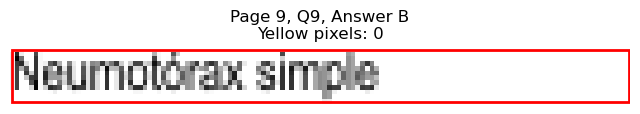

Page 9, Q9 - C: Detected box: x0=327.5, y0=671.7, x1=409.2, y1=682.8
Page 9, Q9, C: Yellow pixels: 1276
Page 9, Q9, C: Total non-white pixels: 1596
Page 9, Q9, C: Yellow percentage: 79.9%


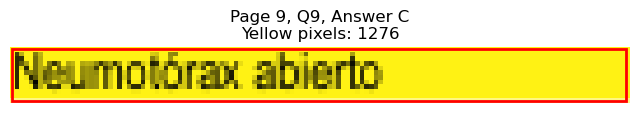

Page 9, Q9 - D: Detected box: x0=327.5, y0=684.3, x1=416.8, y1=695.4
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 456
Page 9, Q9, D: Yellow percentage: 0.0%


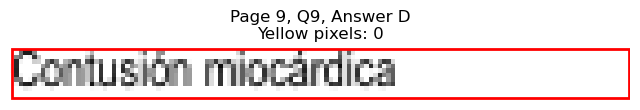


Page 9, Q9 - Selected Answer: C (based on yellow pixel count)




Page 9, Q10 - A: Detected box: x0=68.3, y0=747.4, x1=152.5, y1=758.5
Page 9, Q10, A: Yellow pixels: 135
Page 9, Q10, A: Total non-white pixels: 519
Page 9, Q10, A: Yellow percentage: 26.0%


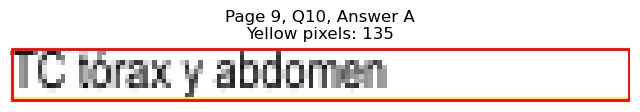

Page 9, Q10 - B: Detected box: x0=68.3, y0=760.2, x1=169.6, y1=771.2
Page 9, Q10, B: Yellow pixels: 1286
Page 9, Q10, B: Total non-white pixels: 1673
Page 9, Q10, B: Yellow percentage: 76.9%


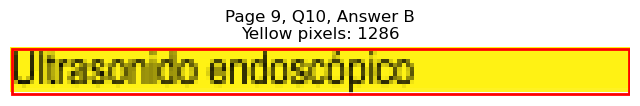

Page 9, Q10 - C: Detected box: x0=327.5, y0=747.4, x1=421.8, y1=758.5
Page 9, Q10, C: Yellow pixels: 0
Page 9, Q10, C: Total non-white pixels: 487
Page 9, Q10, C: Yellow percentage: 0.0%


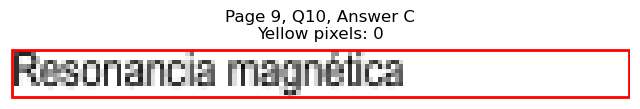

Page 9, Q10 - D: Detected box: x0=327.5, y0=760.2, x1=385.2, y1=771.2
Page 9, Q10, D: Yellow pixels: 0
Page 9, Q10, D: Total non-white pixels: 283
Page 9, Q10, D: Yellow percentage: 0.0%


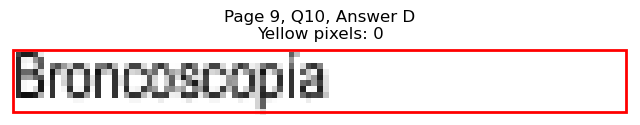


Page 9, Q10 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 7 questions
Page 10, Q1 - A: Detected box: x0=68.3, y0=116.4, x1=287.9, y1=127.4
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 1060
Page 10, Q1, A: Yellow percentage: 0.0%


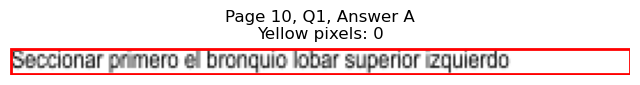

Page 10, Q1 - B: Detected box: x0=68.3, y0=129.0, x1=229.3, y1=140.0
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 987
Page 10, Q1, B: Yellow percentage: 0.0%


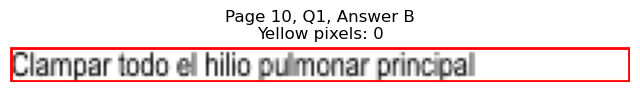

Page 10, Q1 - C: Detected box: x0=68.8, y0=141.7, x1=402.0, y1=152.7
Page 10, Q1, C: Yellow pixels: 3404
Page 10, Q1, C: Total non-white pixels: 4608
Page 10, Q1, C: Yellow percentage: 73.9%


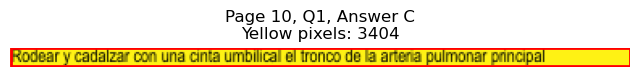

Page 10, Q1 - D: Detected box: x0=68.8, y0=154.3, x1=371.6, y1=165.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 1475
Page 10, Q1, D: Yellow percentage: 0.0%


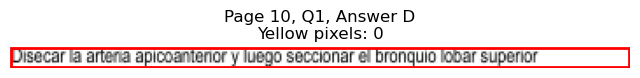


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=68.3, y0=217.4, x1=129.5, y1=228.4
Page 10, Q2, A: Yellow pixels: 112
Page 10, Q2, A: Total non-white pixels: 433
Page 10, Q2, A: Yellow percentage: 25.9%


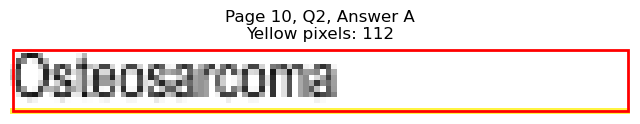

Page 10, Q2 - B: Detected box: x0=68.3, y0=230.0, x1=135.0, y1=241.0
Page 10, Q2, B: Yellow pixels: 1167
Page 10, Q2, B: Total non-white pixels: 1404
Page 10, Q2, B: Yellow percentage: 83.1%


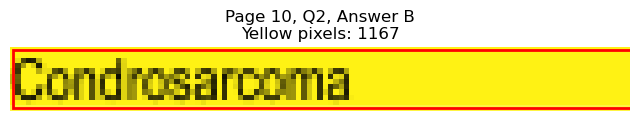

Page 10, Q2 - C: Detected box: x0=327.5, y0=217.4, x1=420.2, y1=228.4
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 460
Page 10, Q2, C: Yellow percentage: 0.0%


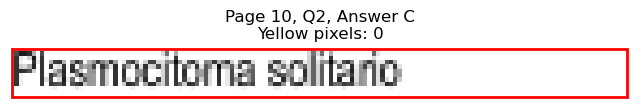

Page 10, Q2 - D: Detected box: x0=327.5, y0=230.0, x1=385.2, y1=241.0
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 298
Page 10, Q2, D: Yellow percentage: 0.0%


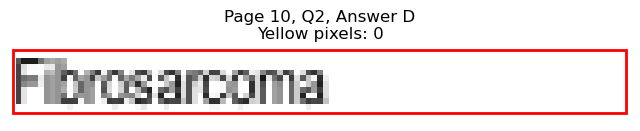


Page 10, Q2 - Selected Answer: B (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=68.3, y0=293.1, x1=116.9, y1=304.2
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 229
Page 10, Q3, A: Yellow percentage: 0.0%


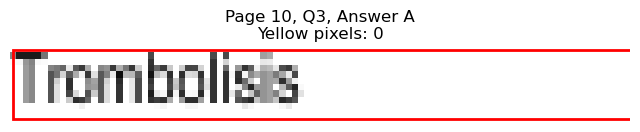

Page 10, Q3 - B: Detected box: x0=68.3, y0=305.7, x1=159.1, y1=316.8
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 464
Page 10, Q3, B: Yellow percentage: 0.0%


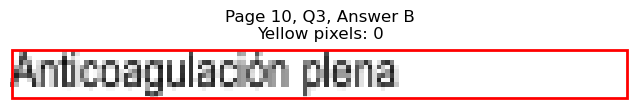

Page 10, Q3 - C: Detected box: x0=327.5, y0=293.1, x1=379.7, y1=304.2
Page 10, Q3, C: Yellow pixels: 103
Page 10, Q3, C: Total non-white pixels: 467
Page 10, Q3, C: Yellow percentage: 22.1%


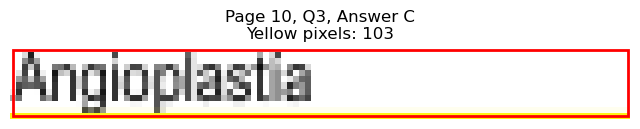

Page 10, Q3 - D: Detected box: x0=327.5, y0=305.7, x1=450.4, y1=316.8
Page 10, Q3, D: Yellow pixels: 1589
Page 10, Q3, D: Total non-white pixels: 2088
Page 10, Q3, D: Yellow percentage: 76.1%


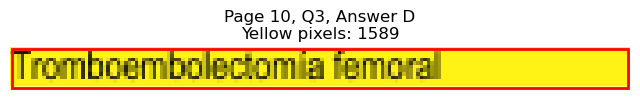


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=68.3, y0=343.6, x1=165.6, y1=354.7
Page 10, Q4, A: Yellow pixels: 148
Page 10, Q4, A: Total non-white pixels: 636
Page 10, Q4, A: Yellow percentage: 23.3%


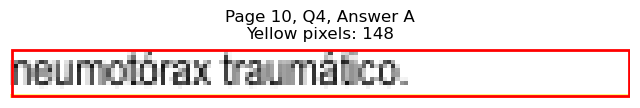

Page 10, Q4 - B: Detected box: x0=68.3, y0=356.2, x1=149.5, y1=367.3
Page 10, Q4, B: Yellow pixels: 1116
Page 10, Q4, B: Total non-white pixels: 1584
Page 10, Q4, B: Yellow percentage: 70.5%


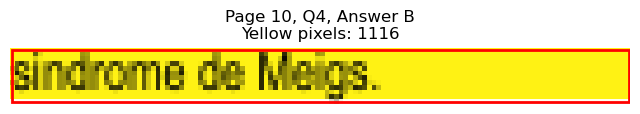

Page 10, Q4 - C: Detected box: x0=327.5, y0=343.6, x1=383.6, y1=354.7
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 283
Page 10, Q4, C: Yellow percentage: 0.0%


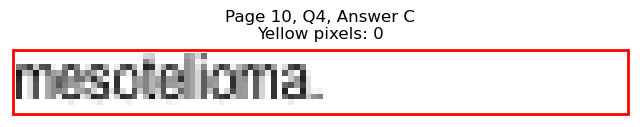

Page 10, Q4 - D: Detected box: x0=327.5, y0=356.2, x1=369.6, y1=367.3
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 207
Page 10, Q4, D: Yellow percentage: 0.0%


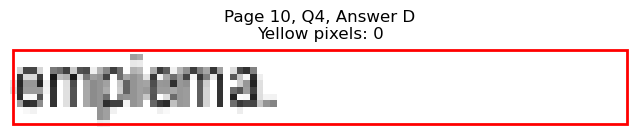


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=68.3, y0=432.0, x1=456.0, y1=443.0
Page 10, Q5, A: Yellow pixels: 3908
Page 10, Q5, A: Total non-white pixels: 5256
Page 10, Q5, A: Yellow percentage: 74.4%


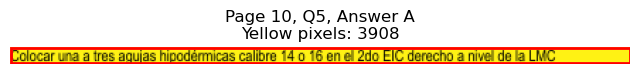

Page 10, Q5 - B: Detected box: x0=68.3, y0=444.6, x1=362.2, y1=455.6
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 1502
Page 10, Q5, B: Yellow percentage: 0.0%


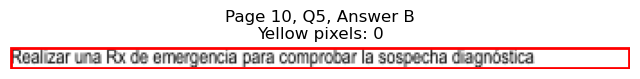

Page 10, Q5 - C: Detected box: x0=68.8, y0=457.2, x1=327.0, y1=468.2
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 1221
Page 10, Q5, C: Yellow percentage: 0.0%


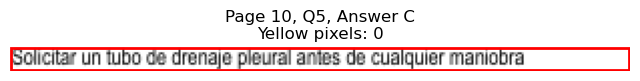

Page 10, Q5 - D: Detected box: x0=68.8, y0=469.8, x1=399.2, y1=480.8
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 1628
Page 10, Q5, D: Yellow percentage: 0.0%


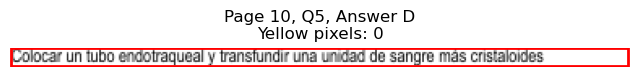


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=68.3, y0=520.3, x1=135.5, y1=531.3
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 348
Page 10, Q6, A: Yellow percentage: 0.0%


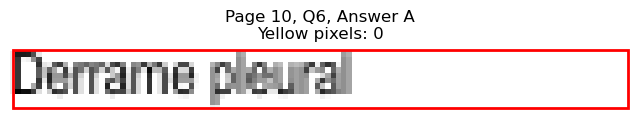

Page 10, Q6 - B: Detected box: x0=68.3, y0=532.9, x1=151.1, y1=543.9
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 429
Page 10, Q6, B: Yellow percentage: 0.0%


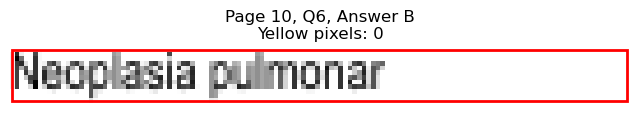

Page 10, Q6 - C: Detected box: x0=327.5, y0=520.3, x1=425.3, y1=531.3
Page 10, Q6, C: Yellow pixels: 1250
Page 10, Q6, C: Total non-white pixels: 1788
Page 10, Q6, C: Yellow percentage: 69.9%


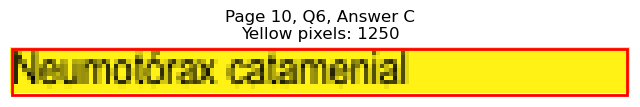

Page 10, Q6 - D: Detected box: x0=327.5, y0=532.9, x1=391.2, y1=543.9
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 334
Page 10, Q6, D: Yellow percentage: 0.0%


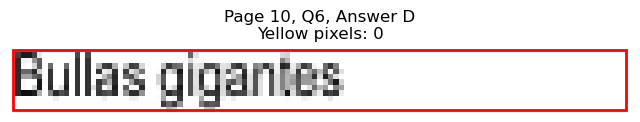


Page 10, Q6 - Selected Answer: C (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=68.3, y0=596.0, x1=182.2, y1=607.0
Page 10, Q7, A: Yellow pixels: 1549
Page 10, Q7, A: Total non-white pixels: 1980
Page 10, Q7, A: Yellow percentage: 78.2%


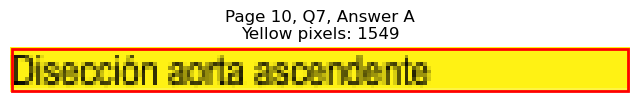

Page 10, Q7 - B: Detected box: x0=68.3, y0=608.6, x1=165.6, y1=619.6
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 481
Page 10, Q7, B: Yellow percentage: 0.0%


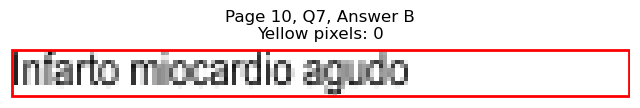

Page 10, Q7 - C: Detected box: x0=327.5, y0=596.0, x1=428.3, y1=607.0
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 503
Page 10, Q7, C: Yellow percentage: 0.0%


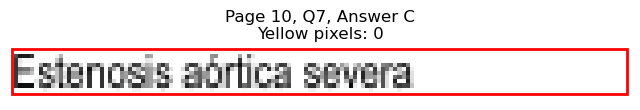

Page 10, Q7 - D: Detected box: x0=327.5, y0=608.6, x1=431.8, y1=619.6
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 538
Page 10, Q7, D: Yellow percentage: 0.0%


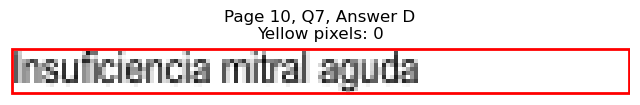


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Está indicado realizar una toracotomía de urge...
1   ¿Cuál es la complicación más frecuente durante...
2   ¿Cuál es la tasa de recidiva en el neumotórax ...
3   Mujer de 65 años, ingresa a emergencia con dis...
4           El transplante cardíaco está indicado en:
..                                                ...
95  Mujer 50 años que ingresa por dolor súbito en ...
96  El síndrome del diafragma poroso se presenta e...
97  Varón de 27 años, albañil, que cae de 10 metro...
98  Mujer de 28 años que ingresa por dolor súbito ...
99  Varón de 45 años que presenta en forma súbita ...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                                             200 - 3   
1                           Absceso de pared torácica   
2                                                 50%   
3                                       Braquiterapia   
4                                   Angina intratable   
..                                                ...   
95                                        Trombolisis   
96                             neumotórax traumático.   
97  Colocar una a tres agujas hipodérmicas calibre...   
98                                    Derrame pleural   
99                         Disección aorta ascendente   

                                             option_B  \
0                                             100 - 2   
1                                 Laceración pulmonar   
2                                              20-30%   
3                                       Quimioterapia   
4                                Edad mayor a 65 años   
..                                                ...   
95                              Anticoagulación plena   
96                                 sindrome de Meigs.   
97  Realizar una Rx de emergencia para comprobar l...   
98                                 Neoplasia pulmonar   
99                            Infarto miocardio agudo   

                                             option_C  \
0                                            1000 - 3   
1                                 Lesión de diafragma   
2                                              25-35%   
3   Hospitalización e indicar exámenes prequirúrgicos   
4             Resistencia vascular pulmonar > 6 Woods   
..                                                ...   
95                                       Angioplastía   
96                                       mesotelioma.   
97  Solicitar un tubo de drenaje pleural antes de ...   
98                              Neumotórax catamenial   
99                           Estenosis aórtica severa   

                                             option_D  
0                                              50 - 4  
1                         Lesión de bronquios lobares  
2                                              36-44%  
3                 Broncoscopía para extirpar el tumor  
4                   Gradiente transpulmonar > 18 mmhg  
..                                                ...  
95                         Tromboembolectomía femoral  
96                                           empiema.  
97  Colocar un tubo endotraqueal y transfundir una...  
98                                    Bullas gigantes  
99                         Insuficiencia mitral aguda  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               A
1               B
2               A
3               D
4               A
..            ...
95              D
96              B
97              A
98              C
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Está indicado realizar una toracotomía de urge...   
1   ¿Cuál es la complicación más frecuente durante...   
2   ¿Cuál es la tasa de recidiva en el neumotórax ...   
3   Mujer de 65 años, ingresa a emergencia con dis...   
4           El transplante cardíaco está indicado en:   
..                                                ...   
95  Mujer 50 años que ingresa por dolor súbito en ...   
96  El síndrome del diafragma poroso se presenta e...   
97  Varón de 27 años, albañil, que cae de 10 metro...   
98  Mujer de 28 años que ingresa por dolor súbito ...   
99  Varón de 45 años que presenta en forma súbita ...   

                                             option_A  \
0                                             200 - 3   
1                           Absceso de pared torácica   
2                                                 50%   
3                                       Braquiterapia   
4                                   Angina intratable   
..                                                ...   
95                                        Trombolisis   
96                             neumotórax traumático.   
97  Colocar una a tres agujas hipodérmicas calibre...   
98                                    Derrame pleural   
99                         Disección aorta ascendente   

                                             option_B  \
0                                             100 - 2   
1                                 Laceración pulmonar   
2                                              20-30%   
3                                       Quimioterapia   
4                                Edad mayor a 65 años   
..                                                ...   
95                              Anticoagulación plena   
96                                 sindrome de Meigs.   
97  Realizar una Rx de emergencia para comprobar l...   
98                                 Neoplasia pulmonar   
99                            Infarto miocardio agudo   

                                             option_C  \
0                                            1000 - 3   
1                                 Lesión de diafragma   
2                                              25-35%   
3   Hospitalización e indicar exámenes prequirúrgicos   
4             Resistencia vascular pulmonar > 6 Woods   
..                                                ...   
95                                       Angioplastía   
96                                       mesotelioma.   
97  Solicitar un tubo de drenaje pleural antes de ...   
98                              Neumotórax catamenial   
99                           Estenosis aórtica severa   

                                             option_D correct_answer  
0                                              50 - 4              A  
1                         Lesión de bronquios lobares              B  
2                                              36-44%              A  
3                 Broncoscopía para extirpar el tumor              D  
4                   Gradiente transpulmonar > 18 mmhg              A  
..                                                ...            ...  
95                         Tromboembolectomía femoral              D  
96                                           empiema.              B  
97  Colocar un tubo endotraqueal y transfundir una...              A  
98                                    Bullas gigantes              C  
99                         Insuficiencia mitral aguda              A  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Documents/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2025/CIRUGIA CARDIOVASCULAR.csv
